# Load Data and Packages 

Import needed packages 

In [21]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

Load data

In [80]:
#load patient metadata
metadata = "data_clinical_patient.txt" 
md = pd.read_csv(metadata, sep="\t", header=0)


#Load count data and transpose to get samples as rows
mRNA = "data_mrna_seq_read_counts.txt"    
count = pd.read_csv(mRNA, sep="\t")

 # Clean dataset 

In [82]:
#Changes the column name to PATIENT_ID
md.rename(columns={"#Patient Identifier": "PATIENT_ID"}, inplace=True)
    
# Set "PATIENT_ID" as the index
md.set_index("PATIENT_ID", inplace=True)

In [83]:
# transpose the count file so it matches the metadata in terms of rows and columns
count = count.set_index("Entrez_Gene_Id").T

# Rename the index to "PATIENT_ID"
count.index.name = "PATIENT_ID"

# show data to make sure I did this right
print(count.head())

Entrez_Gene_Id    1          10         100        1000       10000      \
PATIENT_ID                                                                
TCGA-04-1331-01A         45          5        373       4343        349   
TCGA-04-1332-01A         11          5        254       5875        886   
TCGA-04-1338-01A         11          7        321        379        275   
TCGA-04-1341-01A          4          1       2163        892        129   
TCGA-04-1343-01A         38          2       1406       1106        432   

Entrez_Gene_Id    100008586  100009613  100009667  100009668  100009669  ...  \
PATIENT_ID                                                               ...   
TCGA-04-1331-01A          0          1          1         46          0  ...   
TCGA-04-1332-01A          0          4          8         27          0  ...   
TCGA-04-1338-01A          0          0          3          5          0  ...   
TCGA-04-1341-01A          0          0          3         19          0  .

# Standarize the files
by removing ant extra rows from the metadata and any suffixes from the count

In [88]:
# Remove any extra rows (keep only actual patient data)
md = md[md.index.str.startswith("TCGA")]

# Standardize patient IDs by removing sample suffixes (-01A, -02B, etc.)
count.index = count.index.str.extract(r"(^TCGA-\d{2}-\d{4})")[0]

# Drop any NaN values after extracting patient IDs
count.dropna(inplace=True)

In [90]:
# remove duplicates 
md = md[~md.index.duplicated(keep="first")]
count = count[~count.index.duplicated(keep="first")]

# Normalize the count data

In [93]:
#sum all counts per sample
sample_sums = count.sum(axis=0)
print(sample_sums)

Entrez_Gene_Id
1           4434
10          2948
100       245424
1000     1605061
10000     363609
          ...   
9992         606
9993     2790918
9994      368957
9995         648
9997        9932
Length: 40796, dtype: int64


In [95]:
#divide sum by one million to derive scalefactor
scale_factor = sample_sums/1000000
scale_factor

Entrez_Gene_Id
1        0.004434
10       0.002948
100      0.245424
1000     1.605061
10000    0.363609
           ...   
9992     0.000606
9993     2.790918
9994     0.368957
9995     0.000648
9997     0.009932
Length: 40796, dtype: float64

In [97]:
#divide expression in each sample by corresponding scalefactor
cpm = count.div(scale_factor, axis=1)   #axis=1 is important to divide per sample
cpm


Entrez_Gene_Id,1,10,100,1000,10000,100008586,100009613,100009667,100009668,100009669,...,9988,9989,999,9990,9991,9992,9993,9994,9995,9997
0,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,10148.849797,1696.065129,1519.818763,2705.816165,959.822227,NaN,681.198910,927.643785,6617.752841,0.0,...,5352.731432,3762.955551,1789.592799,2916.276033,3262.374550,0.000000,2069.569941,5233.672217,7716.049383,2114.377769
TCGA-04-1332,2480.829950,1696.065129,1034.943608,3660.297023,2436.683360,NaN,2724.795640,7421.150278,3884.333189,0.0,...,1069.819342,1982.465435,2043.231106,1700.144187,761.170453,0.000000,3326.504039,1295.543925,1543.209877,805.477245
TCGA-04-1338,2480.829950,2374.491180,1307.940544,236.128097,756.306912,NaN,0.000000,2782.931354,719.320961,0.0,...,734.213501,398.512840,1725.628325,1488.642996,957.244744,1650.165017,426.383004,1149.185406,1543.209877,1208.215868
TCGA-04-1341,902.119982,339.213026,8813.318991,555.742118,354.776697,NaN,0.000000,2782.931354,2733.419652,0.0,...,2184.466902,2883.586087,1530.909974,1539.484629,1926.052844,3300.330033,2808.394944,1452.743816,7716.049383,1308.900524
TCGA-04-1343,8570.139829,678.426052,5728.861073,689.070384,1188.089404,NaN,1362.397820,927.643785,4315.925766,0.0,...,1593.219066,2155.698112,1886.245741,1350.353756,1526.362943,4950.495050,2914.453237,929.647628,0.000000,6745.871929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-61-2104,5638.249887,1696.065129,2901.101767,1555.704113,3347.001862,NaN,0.000000,2782.931354,719.320961,0.0,...,4871.736778,2404.283120,3580.194500,4173.081186,3216.121128,8250.825083,8099.485546,2114.067493,0.000000,6242.448651
TCGA-61-2109,902.119982,678.426052,1894.680227,589.385699,371.277939,NaN,681.198910,7421.150278,4459.789958,0.0,...,2844.774423,988.902233,2301.913930,3347.413076,3686.699426,9900.990099,3570.868080,3463.818277,3086.419753,2114.377769
TCGA-61-2110,2480.829950,678.426052,1695.025751,3436.629511,8514.640727,NaN,1362.397820,4638.218924,2014.098691,0.0,...,5068.011675,1620.463518,3992.835979,1580.157934,1417.767951,4950.495050,1794.033361,1314.516326,3086.419753,2215.062424


In [99]:
#check that all samples summed expression == 1M
cpm.sum(axis=0)

Entrez_Gene_Id
1        1000000.0
10       1000000.0
100      1000000.0
1000     1000000.0
10000    1000000.0
           ...    
9992     1000000.0
9993     1000000.0
9994     1000000.0
9995     1000000.0
9997     1000000.0
Length: 40796, dtype: float64

In [101]:
#log2(CPM+1), +1 because you can't take log of zeros
count_norm = np.log2(cpm+1)
count_norm

Entrez_Gene_Id,1,10,100,1000,10000,100008586,100009613,100009667,100009668,100009669,...,9988,9989,999,9990,9991,9992,9993,9994,9995,9997
0,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,13.309171,10.728826,10.570633,11.402381,9.908126,NaN,9.414049,9.858981,12.692344,0.0,...,12.386329,11.878034,10.806222,11.510406,11.672149,0.000000,11.015812,12.353883,12.913834,11.046700
TCGA-04-1332,11.277189,10.728826,10.016730,11.838139,11.251295,NaN,11.412462,12.857621,11.923823,0.0,...,10.064499,10.953808,10.997343,10.732290,9.573970,0.000000,11.700225,10.340455,10.592653,9.655490
TCGA-04-1338,11.277189,11.214010,10.354184,7.889523,9.564734,NaN,0.000000,11.442908,9.492496,0.0,...,9.522019,8.642098,10.753742,10.540751,9.904250,10.689269,8.739386,10.167651,10.592653,10.239856
TCGA-04-1341,9.818774,8.410295,13.105633,9.120865,8.474828,NaN,0.000000,11.442908,11.417019,0.0,...,11.093726,11.494149,10.581116,10.589169,10.912180,11.688832,11.456044,10.505557,12.913834,10.355242
TCGA-04-1343,13.065271,9.408173,12.484284,9.430600,10.215641,NaN,10.412991,9.858981,12.075789,0.0,...,10.638634,11.074609,10.882067,10.400190,10.576827,12.273648,11.509504,9.862091,0.000000,12.720003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-61-2104,12.461288,10.728826,11.502882,10.604279,11.709085,NaN,0.000000,11.442908,9.492496,0.0,...,12.250517,11.231991,11.806225,12.027243,11.651555,13.010498,12.983793,11.046488,0.000000,12.608127
TCGA-61-2109,9.818774,9.408173,10.888500,9.205514,8.540236,NaN,9.414049,12.857621,12.123084,0.0,...,11.474606,9.951142,11.169245,11.709262,11.848505,13.273503,11.802463,11.758564,11.592186,11.046700
TCGA-61-2110,11.277189,9.408173,10.727942,11.747198,13.055899,NaN,10.412991,12.179666,10.976635,0.0,...,12.307489,10.663081,11.963559,10.626766,10.470423,12.273648,10.809795,10.361413,11.592186,11.113783


# Creating a merged file

In [104]:
#using concat to merge the data files
merged1 = pd.concat([md, count], axis=1, join="inner")
# show the data set to make sure I did it correctly
merged1

,Other Patient ID,Patient Primary Tumor Site,Disease Type,Project Name,Project Identifier,Sex,Race Category,Ethnicity Category,Patient's Vital Status,Year of Death,...,9988,9989,999,9990,9991,9992,9993,9994,9995,9997
TCGA-04-1331,6d10d4ee-6331-4bba-93bc-a7b64cc0b22a,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2007,...,4418,4844,8869,1434,6489,0,5776,1931,5,21
TCGA-04-1332,b46263ab-c3ca-4fda-a895-74c7e6e6fe22,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2005,...,883,2552,10126,836,1514,0,9284,478,1,8
TCGA-04-1338,31872f6a-d225-4f91-b38d-4505d19e406c,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,606,513,8552,732,1904,1,1190,424,1,12
TCGA-04-1341,92badeb5-a50e-4a62-a67e-6a8a59c948ab,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,1803,3712,7587,757,3831,2,7838,536,5,13
TCGA-04-1343,b7715ff6-57a6-4513-9447-aa8bc93f16d4,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2002,...,1315,2775,9348,664,3036,3,8134,343,0,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-61-2104,05263959-c4f5-4540-b6d2-d8c8a128861f,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NaN,Alive,NaN,...,4021,3095,17743,2052,6397,5,22605,780,0,62
TCGA-61-2109,dc5a6ce7-01e5-408d-812e-e3e0ddc1cde5,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2000,...,2348,1273,11408,1646,7333,6,9966,1278,2,21
TCGA-61-2110,88180134-710f-46ea-9b06-5e5d860d6d9f,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2001,...,4183,2086,19788,777,2820,3,5007,485,2,22
TCGA-61-2111,91a17d40-c8cb-4cce-b306-966382a8fe4a,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,1567,4364,32806,1040,3597,2,5449,818,1,5


In [106]:
# Drop rows where DFS_MONTHS is NaN (missing)
filtered = merged1.dropna(subset=["Disease Free Status"])

#Remove one sample where it says DFS_STATUS not avalible 
filtered1 = filtered[filtered["Disease Free Status"] != "[Not Available]"]

#show the data 
filtered1.head()

,Other Patient ID,Patient Primary Tumor Site,Disease Type,Project Name,Project Identifier,Sex,Race Category,Ethnicity Category,Patient's Vital Status,Year of Death,...,9988,9989,999,9990,9991,9992,9993,9994,9995,9997
TCGA-04-1331,6d10d4ee-6331-4bba-93bc-a7b64cc0b22a,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2007,...,4418,4844,8869,1434,6489,0,5776,1931,5,21
TCGA-04-1341,92badeb5-a50e-4a62-a67e-6a8a59c948ab,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,1803,3712,7587,757,3831,2,7838,536,5,13
TCGA-04-1365,0484a929-7a7f-4926-8d25-470ddab082ec,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,2644,5350,15418,1394,7916,1,8169,3051,1,64
TCGA-04-1514,e9483296-cb91-497a-b955-39a3c3289dac,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2008,...,5634,6439,20324,2239,7555,8,5532,2300,15,4
TCGA-04-1519,e9b5336e-d724-4e7d-8c81-1147abd0a80d,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,NaN,NaN,Alive,NaN,...,2295,1371,17831,972,2489,0,6916,601,1,5


In [108]:
# make Patient ID the index to use for following steps
filtered1.index.name = "Patient ID"

# show it again 
filtered1.head()

,Other Patient ID,Patient Primary Tumor Site,Disease Type,Project Name,Project Identifier,Sex,Race Category,Ethnicity Category,Patient's Vital Status,Year of Death,...,9988,9989,999,9990,9991,9992,9993,9994,9995,9997
Patient ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,6d10d4ee-6331-4bba-93bc-a7b64cc0b22a,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2007,...,4418,4844,8869,1434,6489,0,5776,1931,5,21
TCGA-04-1341,92badeb5-a50e-4a62-a67e-6a8a59c948ab,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,1803,3712,7587,757,3831,2,7838,536,5,13
TCGA-04-1365,0484a929-7a7f-4926-8d25-470ddab082ec,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,2644,5350,15418,1394,7916,1,8169,3051,1,64
TCGA-04-1514,e9483296-cb91-497a-b955-39a3c3289dac,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2008,...,5634,6439,20324,2239,7555,8,5532,2300,15,4
TCGA-04-1519,e9b5336e-d724-4e7d-8c81-1147abd0a80d,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,NaN,NaN,Alive,NaN,...,2295,1371,17831,972,2489,0,6916,601,1,5


# Make DFS a binary
Disease Free Status is states as 1:progressed/recurred and 0: disease free. Here we make it binary with 1.0 and 0.0

In [111]:
# this function standardizes DFS_STATUS values
def clean_dfs_status(value):
    if value == "1:Recurred/Progressed" :
        return 1.0  # Recurrence/Progression
    else:
        return 0.0 #  Disease-free

# Apply the cleaning function
filtered1["DFS_STATUS_BINARY"] = filtered1["Disease Free Status"].apply(clean_dfs_status)

#show the data to check if the function was successfully implemented 
filtered1.head()

C:\Users\mahal\AppData\Local\Temp\ipykernel_12448\3829723218.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered1["DFS_STATUS_BINARY"] = filtered1["Disease Free Status"].apply(clean_dfs_status)


,Other Patient ID,Patient Primary Tumor Site,Disease Type,Project Name,Project Identifier,Sex,Race Category,Ethnicity Category,Patient's Vital Status,Year of Death,...,9989,999,9990,9991,9992,9993,9994,9995,9997,DFS_STATUS_BINARY
Patient ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,6d10d4ee-6331-4bba-93bc-a7b64cc0b22a,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2007,...,4844,8869,1434,6489,0,5776,1931,5,21,1.0
TCGA-04-1341,92badeb5-a50e-4a62-a67e-6a8a59c948ab,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,3712,7587,757,3831,2,7838,536,5,13,0.0
TCGA-04-1365,0484a929-7a7f-4926-8d25-470ddab082ec,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,5350,15418,1394,7916,1,8169,3051,1,64,1.0
TCGA-04-1514,e9483296-cb91-497a-b955-39a3c3289dac,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2008,...,6439,20324,2239,7555,8,5532,2300,15,4,0.0
TCGA-04-1519,e9b5336e-d724-4e7d-8c81-1147abd0a80d,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,NaN,NaN,Alive,NaN,...,1371,17831,972,2489,0,6916,601,1,5,1.0


# Combine Stages 

In [116]:
# combine the supstages into main stages
stage_mapping = {
    'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II', 'Stage IIC': 'Stage II',
    'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III', 'Stage IIIC': 'Stage III',
    'Stage IV': 'Stage IV'
}


filtered1['FIGO Stage'] = filtered1['FIGO Stage'].replace(stage_mapping)

# Verify the changes
print(filtered1['FIGO Stage'].unique())  # Should print ['II', 'III', 'IV']


C:\Users\mahal\AppData\Local\Temp\ipykernel_12448\1183540747.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered1['FIGO Stage'] = filtered1['FIGO Stage'].replace(stage_mapping)


array(['Stage III', nan, 'Stage IV', 'Stage II'], dtype=object)

In [118]:
# since the outcome shows a nan, this cleans out any missing stage 
missing_figo_samples =filtered1[filtered1["FIGO Stage"].isna()].index

# Remove these samples from both datasets
filtered1 = filtered1.drop(missing_figo_samples)

#verify changes
print(filtered1['FIGO Stage'].unique())  # Should print ['II', 'III', 'IV']

['Stage III' 'Stage IV' 'Stage II']


# Explore Metadata


([0, 1, 2],
 [Text(0, 0, 'Stage III'), Text(1, 0, 'Stage IV'), Text(2, 0, 'Stage II')])

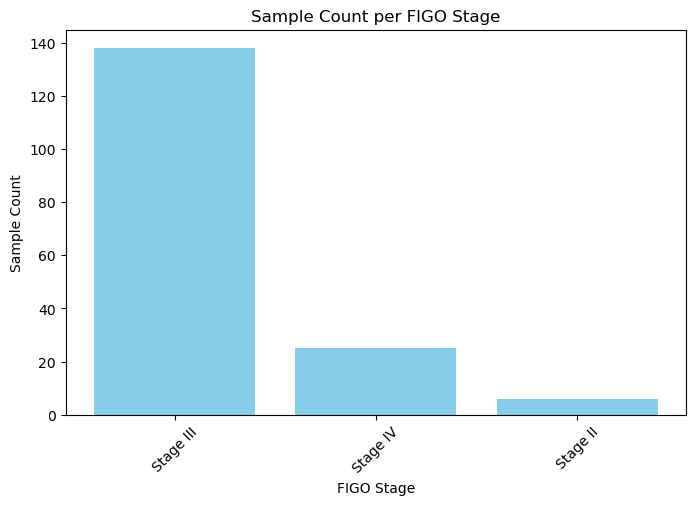

In [608]:
stage_counts = pd.read_csv("new stage count.csv")

# Plot the stage counts as a bar chart
plt.figure(figsize=(8, 5))
plt.bar(stage_counts["FIGO_Stage"], stage_counts["Sample Count"], color="skyblue")
plt.xlabel("FIGO Stage")
plt.ylabel("Sample Count")
plt.title("Sample Count per FIGO Stage")
plt.xticks(rotation=45)  

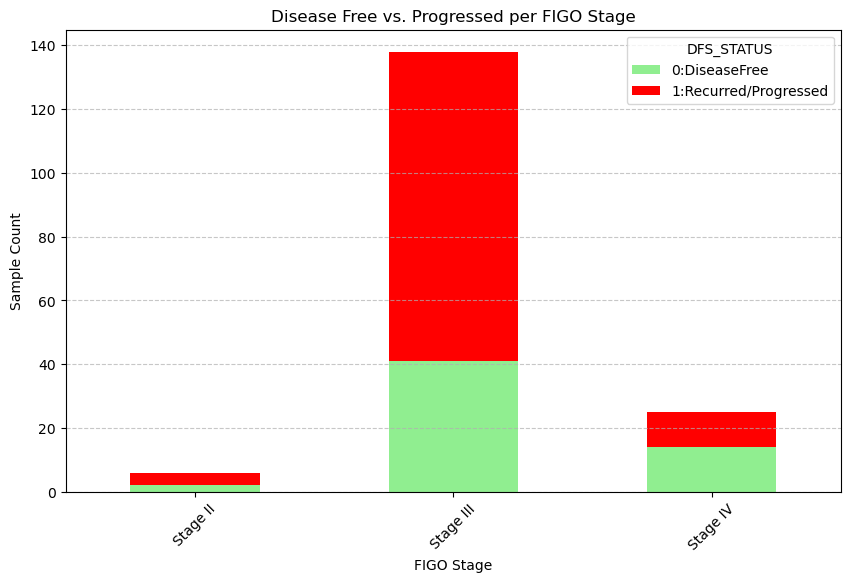

In [617]:
#show stage and DFS
stage_dfs_counts = filtered1.groupby(["FIGO Stage", "Disease Free Status"]).size().unstack(fill_value=0)


#Plot the Data
stage_dfs_counts.plot(kind="bar", stacked=True, figsize=(10, 6), color=["lightgreen", "red"])
plt.xlabel("FIGO Stage")
plt.ylabel("Sample Count")
plt.title("Disease Free vs. Progressed per FIGO Stage")
plt.xticks(rotation=45)
plt.legend(title="DFS_STATUS")
plt.grid(axis="y", linestyle="--", alpha=0.7)

#save the plot 
plt.savefig("DFS VS FIGO.png", dpi=300, bbox_inches='tight')
#Show the plot
plt.show()

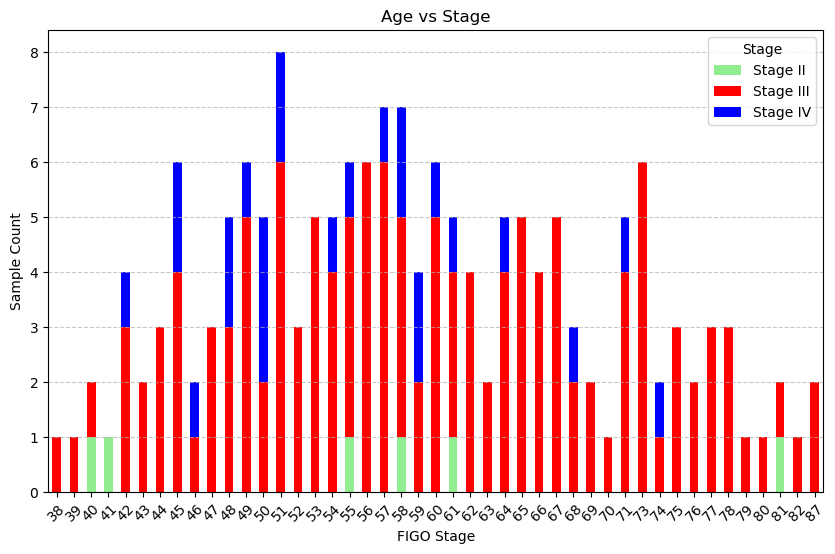

In [621]:
#show stage and diagonsis age
stage_dfs_counts = filtered1.groupby(["Diagnosis Age", "FIGO Stage"]).size().unstack(fill_value=0)


#Plot the Data
stage_dfs_counts.plot(kind="bar", stacked=True, figsize=(10, 6), color=["lightgreen", "red", "blue"])
plt.xlabel("FIGO Stage")
plt.ylabel("Sample Count")
plt.title("Age vs Stage")
plt.xticks(rotation=45)
plt.legend(title="Stage")
plt.grid(axis="y", linestyle="--", alpha=0.7)

#save the plot 
plt.savefig("Age VS FIGO.png", dpi=300, bbox_inches='tight')
#Show the plot
plt.show()

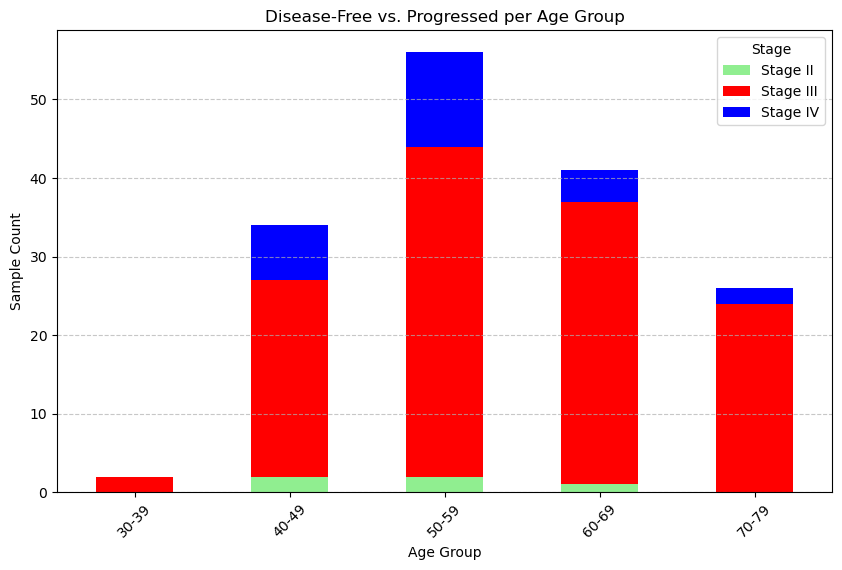

In [627]:
# Ensuring Diagnosis Age is numeric
filtered1["Diagnosis Age"] = pd.to_numeric(filtered1["Diagnosis Age"], errors="coerce")

# Define age groups starting 38-87 grouped in subgroups of 10 years
age_bins = list(range(30, 90, 10)) 
age_labels = [f"{age}-{age+9}" for age in age_bins[:-1]]  

# Add a new column for age groups
filtered1["Age_Group"] = pd.cut(filtered1["Diagnosis Age"], bins=age_bins, labels=age_labels, right=False)

# Drop NaN values
filtered1 = filtered1.dropna(subset=["Age_Group"])

# Group by age groups instead of individual ages
stage_dfs_counts = filtered1.groupby(["Age_Group", "FIGO Stage"]).size().unstack(fill_value=0)

stage_dfs_counts.plot(kind="bar", stacked=True, figsize=(10, 6), color=["lightgreen", "red", "blue"])
plt.xlabel("Age Group")
plt.ylabel("Sample Count")
plt.title("Disease-Free vs. Progressed per Age Group")
plt.xticks(rotation=45)
plt.legend(title="Stage")
plt.grid(axis="y", linestyle="--", alpha=0.7)

#save the plot 
plt.savefig("Age group VS FIGO.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Kaplan Meier Survival 

In [629]:
!pip install lifelines

In [633]:
filtered1['OS_event'] = filtered1['Overall Survival Status'].map({'1:DECEASED': 1, '0:LIVING': 0})

C:\Users\mahal\anaconda3\Lib\site-packages\lifelines\utils\__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
C:\Users\mahal\anaconda3\Lib\site-packages\lifelines\utils\__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
C:\Users\mahal\anaconda3\Lib\site-packages\lifelines\utils\__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


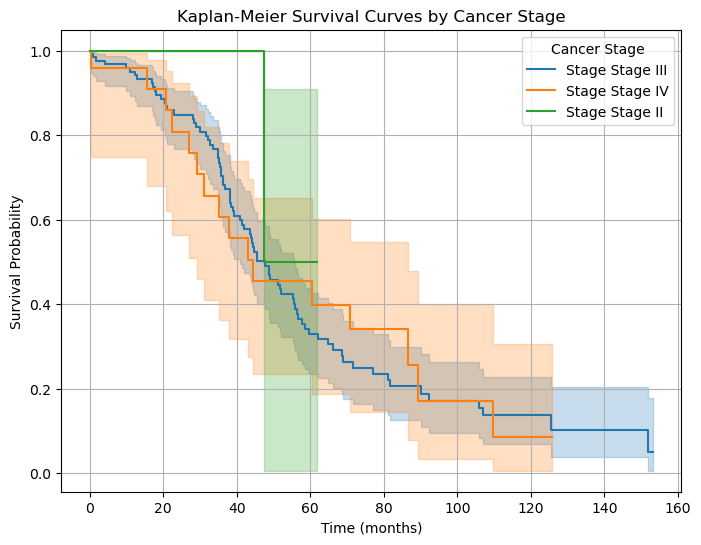

In [643]:
from lifelines import KaplanMeierFitter
# Load data
survival_data = filtered1[['Overall Survival (Months)', 'OS_event', 'FIGO Stage']].dropna()

# Initialize Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Define unique cancer stages
stages = survival_data['FIGO Stage'].unique()


plt.figure(figsize=(8, 6))

for stage in stages:
    stage_data = survival_data[survival_data['FIGO Stage'] == stage]
    kmf.fit(stage_data['Overall Survival (Months)'], event_observed=stage_data['OS_event'], label=f"Stage {stage}")
    kmf.plot_survival_function()


plt.title("Kaplan-Meier Survival Curves by Cancer Stage")
plt.xlabel("Time (months)")  
plt.ylabel("Survival Probability")
plt.legend(title="Cancer Stage")
plt.grid(True)
#save the plot 
plt.savefig("KMA.png", dpi=300, bbox_inches='tight')

plt.show()

C:\Users\mahal\anaconda3\Lib\site-packages\lifelines\utils\__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
C:\Users\mahal\anaconda3\Lib\site-packages\lifelines\utils\__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
C:\Users\mahal\anaconda3\Lib\site-packages\lifelines\utils\__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


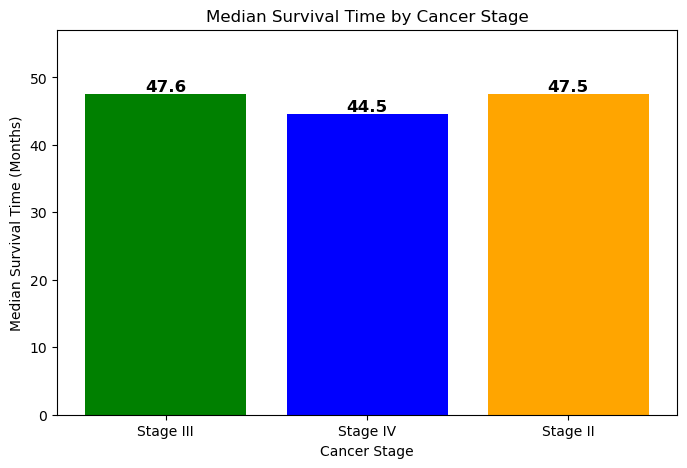

In [651]:
# Store median survival times
median_survival = {}

for stage in filtered1['FIGO Stage'].unique():
    stage_data = filtered1[filtered1['FIGO Stage'] == stage]
    kmf.fit(stage_data['Overall Survival (Months)'], stage_data['OS_event'])
    median_survival[stage] = kmf.median_survival_time_

# Convert to DataFrame for easy plotting
median_df = pd.DataFrame(list(median_survival.items()), columns=['Stage', 'Median Survival (Months)'])

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(median_df['Stage'], median_df['Median Survival (Months)'], color=['green', 'blue', 'orange'])

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Cancer Stage")
plt.ylabel("Median Survival Time (Months)")
plt.title("Median Survival Time by Cancer Stage")
plt.ylim(0, max(median_df['Median Survival (Months)']) * 1.2)
plt.show()

# Create Late vs early progression cutoffs
first subset only those how have progressed/recurred and then categorize them as early or late recurrence 

In [129]:
# Convert "DFS months" to numeric
filtered1["Disease Free (Months)"] = pd.to_numeric(filtered1["Disease Free (Months)"], errors="coerce")

In [131]:
#rename the data and extract only patients who experienced disease progression or recurrence
progressed = filtered1[filtered1["DFS_STATUS_BINARY"] == 1.0].copy()

# verify changes 
progressed

,Other Patient ID,Patient Primary Tumor Site,Disease Type,Project Name,Project Identifier,Sex,Race Category,Ethnicity Category,Patient's Vital Status,Year of Death,...,9989,999,9990,9991,9992,9993,9994,9995,9997,DFS_STATUS_BINARY
Patient ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,6d10d4ee-6331-4bba-93bc-a7b64cc0b22a,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2007,...,4844,8869,1434,6489,0,5776,1931,5,21,1.0
TCGA-04-1365,0484a929-7a7f-4926-8d25-470ddab082ec,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,5350,15418,1394,7916,1,8169,3051,1,64,1.0
TCGA-04-1519,e9b5336e-d724-4e7d-8c81-1147abd0a80d,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,NaN,NaN,Alive,NaN,...,1371,17831,972,2489,0,6916,601,1,5,1.0
TCGA-04-1536,1fe19c6b-71d0-4b07-923b-74ea32210db0,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,BLACK OR AFRICAN AMERICAN,NaN,Dead,2003,...,1632,16166,525,4189,0,6881,939,1,4,1.0
TCGA-04-1651,55153632-1673-487a-85c0-f156377db1fc,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2007,...,3306,13782,1161,5137,1,9831,1386,4,25,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-61-2088,242943fe-1fa0-4a12-8f7e-9c6c4af1194d,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,1657,7882,2741,2249,7,3019,1626,3,16,1.0
TCGA-61-2098,eb7c3b35-7a5e-4621-b31f-9775c51f9a23,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NaN,Alive,NaN,...,3886,23690,2624,4140,2,9880,2335,0,10,1.0
TCGA-61-2101,5d1a54fe-e0df-4c17-b623-b649a136dc82,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2003,...,3462,35431,1579,5261,2,26528,886,1,7,1.0


In [133]:
# Assign progression category based on 13.8-month threshold
progressed["recurrence_category"] = progressed["Disease Free (Months)"].apply(
    lambda x: "late recurrance" if x > 18 else "early recurrence"
)

# show data 
progressed

,Other Patient ID,Patient Primary Tumor Site,Disease Type,Project Name,Project Identifier,Sex,Race Category,Ethnicity Category,Patient's Vital Status,Year of Death,...,999,9990,9991,9992,9993,9994,9995,9997,DFS_STATUS_BINARY,recurrence_category
Patient ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,6d10d4ee-6331-4bba-93bc-a7b64cc0b22a,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2007,...,8869,1434,6489,0,5776,1931,5,21,1.0,early recurrence
TCGA-04-1365,0484a929-7a7f-4926-8d25-470ddab082ec,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,15418,1394,7916,1,8169,3051,1,64,1.0,late recurrance
TCGA-04-1519,e9b5336e-d724-4e7d-8c81-1147abd0a80d,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,NaN,NaN,Alive,NaN,...,17831,972,2489,0,6916,601,1,5,1.0,early recurrence
TCGA-04-1536,1fe19c6b-71d0-4b07-923b-74ea32210db0,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,BLACK OR AFRICAN AMERICAN,NaN,Dead,2003,...,16166,525,4189,0,6881,939,1,4,1.0,late recurrance
TCGA-04-1651,55153632-1673-487a-85c0-f156377db1fc,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2007,...,13782,1161,5137,1,9831,1386,4,25,1.0,late recurrance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-61-2088,242943fe-1fa0-4a12-8f7e-9c6c4af1194d,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,7882,2741,2249,7,3019,1626,3,16,1.0,late recurrance
TCGA-61-2098,eb7c3b35-7a5e-4621-b31f-9775c51f9a23,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NaN,Alive,NaN,...,23690,2624,4140,2,9880,2335,0,10,1.0,late recurrance
TCGA-61-2101,5d1a54fe-e0df-4c17-b623-b649a136dc82,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2003,...,35431,1579,5261,2,26528,886,1,7,1.0,late recurrance


In [135]:
# look at the columns to check for the new column 
progressed.columns

Index([          'Other Patient ID', 'Patient Primary Tumor Site',
                     'Disease Type',               'Project Name',
               'Project Identifier',                        'Sex',
                    'Race Category',         'Ethnicity Category',
           'Patient's Vital Status',              'Year of Death',
       ...
                                999,                         9990,
                               9991,                         9992,
                               9993,                         9994,
                               9995,                         9997,
                'DFS_STATUS_BINARY',        'recurrence_category'],
      dtype='object', length=40822)

In [137]:
# determine the index of the dataset
progressed.index

Index(['TCGA-04-1331', 'TCGA-04-1365', 'TCGA-04-1519', 'TCGA-04-1536',
       'TCGA-04-1651', 'TCGA-09-0367', 'TCGA-09-0369', 'TCGA-09-1659',
       'TCGA-09-1673', 'TCGA-09-2051',
       ...
       'TCGA-61-1918', 'TCGA-61-1919', 'TCGA-61-1995', 'TCGA-61-2008',
       'TCGA-61-2012', 'TCGA-61-2088', 'TCGA-61-2098', 'TCGA-61-2101',
       'TCGA-61-2109', 'TCGA-61-2111'],
      dtype='object', name='Patient ID', length=112)

In [141]:
#reset the index so Patient ID is a column and not an index
progressed= progressed.reset_index()

In [143]:
# Identify the gene expression columns (everything after "DFS_MONTHS")
gene = progressed.columns[progressed.columns.get_loc("Disease Free (Months)") + 1:]

# Reshape the data by setting patient IDs as columns and gene identifiers as rows
gene_expr = progressed.set_index("Patient ID")[gene].T

In [147]:
#rename the index to Gene
gene_expr.index.name = "Gene"

# confirm the change and show the data
gene_expr.head()

Patient ID,TCGA-04-1331,TCGA-04-1365,TCGA-04-1519,TCGA-04-1536,TCGA-04-1651,TCGA-09-0367,TCGA-09-0369,TCGA-09-1659,TCGA-09-1673,TCGA-09-2051,...,TCGA-61-1918,TCGA-61-1919,TCGA-61-1995,TCGA-61-2008,TCGA-61-2012,TCGA-61-2088,TCGA-61-2098,TCGA-61-2101,TCGA-61-2109,TCGA-61-2111
Gene,,,,,,,,,,,,,,,,,,,,,
1,45,4,5,6,7,1,10,6,10,10,...,10,8,19,20,23,51,54,7,4,12
10,5,12,12,2,8,9,37,3,13,9,...,0,2,9,1,0,0,3,4,2,1
100,373,764,393,237,956,224,1516,1045,190,1495,...,521,591,458,437,596,245,910,813,465,640
1000,4343,10619,4637,3550,846,559,12571,1073,3444,1020,...,7284,14521,3561,2376,1936,3804,1839,49529,946,197
10000,349,208,364,242,147,81,321,447,3568,391,...,640,585,347,1375,660,127,609,870,135,320


In [150]:
#subset dataframe
print(gene_expr.shape)
expr_filt = gene_expr.loc[sample_sums.index]
print(expr_filt.shape)
expr_filt.index.name = "Gene"
expr_filt

(40798, 112)
(40796, 112)


Patient ID,TCGA-04-1331,TCGA-04-1365,TCGA-04-1519,TCGA-04-1536,TCGA-04-1651,TCGA-09-0367,TCGA-09-0369,TCGA-09-1659,TCGA-09-1673,TCGA-09-2051,...,TCGA-61-1918,TCGA-61-1919,TCGA-61-1995,TCGA-61-2008,TCGA-61-2012,TCGA-61-2088,TCGA-61-2098,TCGA-61-2101,TCGA-61-2109,TCGA-61-2111
Gene,,,,,,,,,,,,,,,,,,,,,
1,45,4,5,6,7,1,10,6,10,10,...,10,8,19,20,23,51,54,7,4,12
10,5,12,12,2,8,9,37,3,13,9,...,0,2,9,1,0,0,3,4,2,1
100,373,764,393,237,956,224,1516,1045,190,1495,...,521,591,458,437,596,245,910,813,465,640
1000,4343,10619,4637,3550,846,559,12571,1073,3444,1020,...,7284,14521,3561,2376,1936,3804,1839,49529,946,197
10000,349,208,364,242,147,81,321,447,3568,391,...,640,585,347,1375,660,127,609,870,135,320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,0,1,0,0,1,0,1,2,30,2,...,4,1,1,1,2,7,2,2,6,2
9993,5776,8169,6916,6881,9831,12143,16132,7028,3383,9149,...,7551,5015,11724,12319,5296,3019,9880,26528,9966,5449
9994,1931,3051,601,939,1386,275,814,543,1703,1533,...,489,597,1898,566,629,1626,2335,886,1278,818


# DESeq 2 Prep and Analysis

In [153]:
#transpose for correct format into DESeq2
expr_filt_T = expr_filt.T
expr_filt_T

Gene,1,10,100,1000,10000,100008586,100009613,100009667,100009668,100009669,...,9988,9989,999,9990,9991,9992,9993,9994,9995,9997
Patient ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,45,5,373,4343,349,0,1,1,46,0,...,4418,4844,8869,1434,6489,0,5776,1931,5,21
TCGA-04-1365,4,12,764,10619,208,0,0,3,13,0,...,2644,5350,15418,1394,7916,1,8169,3051,1,64
TCGA-04-1519,5,12,393,4637,364,0,10,1,22,0,...,2295,1371,17831,972,2489,0,6916,601,1,5
TCGA-04-1536,6,2,237,3550,242,0,0,1,10,0,...,1167,1632,16166,525,4189,0,6881,939,1,4
TCGA-04-1651,7,8,956,846,147,0,1,2,9,0,...,3492,3306,13782,1161,5137,1,9831,1386,4,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-61-2088,51,0,245,3804,127,0,2,7,16,0,...,5637,1657,7882,2741,2249,7,3019,1626,3,16
TCGA-61-2098,54,3,910,1839,609,0,0,4,26,0,...,3995,3886,23690,2624,4140,2,9880,2335,0,10
TCGA-61-2101,7,4,813,49529,870,0,6,4,2,0,...,2581,3462,35431,1579,5261,2,26528,886,1,7


In [155]:
!pip install pydeseq2

In [157]:
import os
import pickle as pkl
from scipy import stats

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data
from pydeseq2.preprocessing import deseq2_norm

In [159]:
#check the index
progressed.index

RangeIndex(start=0, stop=112, step=1)

In [161]:
# Ensure "Patient ID" is set as the index
progressed = progressed.set_index("Patient ID")

In [163]:
expr_filt_T.index

Index(['TCGA-04-1331', 'TCGA-04-1365', 'TCGA-04-1519', 'TCGA-04-1536',
       'TCGA-04-1651', 'TCGA-09-0367', 'TCGA-09-0369', 'TCGA-09-1659',
       'TCGA-09-1673', 'TCGA-09-2051',
       ...
       'TCGA-61-1918', 'TCGA-61-1919', 'TCGA-61-1995', 'TCGA-61-2008',
       'TCGA-61-2012', 'TCGA-61-2088', 'TCGA-61-2098', 'TCGA-61-2101',
       'TCGA-61-2109', 'TCGA-61-2111'],
      dtype='object', name='Patient ID', length=112)

In [165]:
# Ensure recurrence_category is categorical for the DESeq2 analysis
progressed["recurrence_category"]= progressed["recurrence_category"].astype("category")

In [167]:
#initialize DESeq2 object
inference = DefaultInference(n_cpus=8)
#this is just a technical requirement 
progressed.recurrence_category.astype("category")
dds = DeseqDataSet(
    counts=expr_filt_T,
    metadata=progressed,
    design_factors="recurrence_category",   #differential expression across category
    refit_cooks=True,
    inference=inference,
)

C:\Users\mahal\anaconda3\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\mahal\AppData\Local\Temp\ipykernel_12448\1586676774.py:5: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(


In [169]:
#run DESeq2 pipeline
dds.deseq2()

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.35 seconds.

Fitting dispersions...
... done in 51.11 seconds.

Fitting dispersion trend curve...
... done in 13.28 seconds.

Fitting MAP dispersions...
... done in 53.03 seconds.

Fitting LFCs...
... done in 22.37 seconds.

Calculating cook's distance...
... done in 0.73 seconds.

Replacing 3338 outlier genes.

Fitting dispersions...
... done in 5.65 seconds.

Fitting MAP dispersions...
... done in 7.20 seconds.

Fitting LFCs...
... done in 4.10 seconds.



In [171]:
dds

AnnData object with n_obs × n_vars = 112 × 40796
    obs: 'Other Patient ID', 'Patient Primary Tumor Site', 'Disease Type', 'Project Name', 'Project Identifier', 'Sex', 'Race Category', 'Ethnicity Category', "Patient's Vital Status", 'Year of Death', 'Primary Diagnosis', 'Year of Diagnosis', 'FIGO Stage', 'Biopsy Site', 'ICD-10 Classification', 'Diagnosis Age', 'Morphology', 'Prior Treatment', 'Prior Malignancy', 'Project State', 'Overall Survival Status', 'Overall Survival (Months)', 'Disease Free Status', 'Disease Free (Months)', 1, 10, 100, 1000, 10000, 100008586, 100009613, 100009667, 100009668, 100009669, 100009676, 10001, 10002, 10003, 100033392, 100033398, 100033407, 100033409, 100033411, 100033413, 100033414, 100033415, 100033416, 100033417, 100033418, 100033419, 100033420, 100033421, 100033422, 100033423, 100033424, 100033425, 100033426, 100033427, 100033428, 100033429, 100033430, 100033431, 100033432, 100033433, 100033434, 100033435, 100033436, 100033437, 100033438, 100033439

In [173]:
dds.obsm["size_factors"]

array([1.20657582, 1.53378836, 0.95942697, 0.62264848, 1.37867835,
       0.95978786, 1.58979852, 1.25016712, 1.09608496, 1.89173232,
       1.65021988, 1.01988556, 0.76828865, 0.57975729, 1.13489298,
       0.29543225, 0.83933667, 0.97493287, 0.62522464, 0.86858862,
       0.43473843, 0.83057442, 0.74697287, 0.68013318, 0.28150294,
       1.49093825, 1.36661034, 1.38813087, 0.60931156, 1.19503609,
       0.99581904, 1.23952048, 0.83943988, 1.11611831, 0.34497216,
       0.70423148, 0.64726891, 0.78306748, 1.03208481, 1.24528165,
       0.52562505, 1.54238652, 0.88040087, 0.54219554, 1.43523146,
       1.7042679 , 1.14623444, 0.78992405, 0.88427126, 1.2827726 ,
       1.14390834, 0.76085234, 1.24450877, 1.44970484, 0.90757242,
       1.67782066, 1.32010725, 1.33699624, 1.21352563, 1.57002997,
       1.23921883, 1.3086517 , 1.43686825, 1.39720389, 1.03592731,
       1.52676357, 1.21170924, 1.316659  , 0.83201505, 0.73528287,
       0.55949374, 0.81049023, 1.60789712, 0.94324586, 1.12111

In [175]:
print(dds.varm["LFC"])

       Intercept  recurrence_category[T.late recurrance]
Gene                                                    
1       2.588228                               -0.163170
10      1.952263                               -0.340063
100     6.518260                               -0.053242
1000    8.492238                               -0.100157
10000   6.608098                                0.031725
...          ...                                     ...
9992    0.196343                                0.537253
9993    8.779927                                0.082498
9994    6.708262                                0.173083
9995    0.161961                                0.244037
9997    3.081665                                0.186340

[40796 rows x 2 columns]


In [177]:
#double check that recurrence column is category to pass into the analysis and not get an error
progressed.recurrence_category.astype("category")

Patient ID
TCGA-04-1331    early recurrence
TCGA-04-1365     late recurrance
TCGA-04-1519    early recurrence
TCGA-04-1536     late recurrance
TCGA-04-1651     late recurrance
                      ...       
TCGA-61-2088     late recurrance
TCGA-61-2098     late recurrance
TCGA-61-2101     late recurrance
TCGA-61-2109     late recurrance
TCGA-61-2111    early recurrence
Name: recurrence_category, Length: 112, dtype: category
Categories (2, object): ['early recurrence', 'late recurrance']

In [179]:
#differential expression stats 
#late recurrence is our reference and early recurrence is the experimental group here for all the analysis
stat_res = DeseqStats(dds, contrast=["recurrence_category", 'early recurrence', 'late recurrance'], inference=inference)
stat_res.summary()

Running Wald tests...
... done in 8.34 seconds.



Log2 fold change & Wald test p-value: recurrence_category early recurrence vs late recurrance
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Gene                                                                      
1        12.201617        0.235405  0.213901  1.100530  0.271101  0.782496
10        6.040187        0.490608  0.369342  1.328328  0.184070  0.716640
100     659.381682        0.076812  0.142167  0.540297  0.588992  0.922728
1000   4636.028956        0.144497  0.304722  0.474192  0.635363  0.935910
10000   753.397311       -0.045769  0.254635 -0.179744  0.857353  0.980373
...            ...             ...       ...       ...       ...       ...
9992      1.685431       -0.775093  0.370868 -2.089943  0.036623  0.443955
9993   6791.719125       -0.119019  0.106440 -1.118182  0.263489  0.778500
9994    899.177700       -0.249706  0.130412 -1.914747  0.055525  0.508759
9995      1.424381       -0.352071  0.352566 -0.998594  0.317991  0.812241
9997  

In [180]:
# Count the occurrences of each category 
progression_counts = progressed["recurrence_category"].value_counts()
progression_counts

recurrence_category
late recurrance     58
early recurrence    54
Name: count, dtype: int64

In [181]:
resdf = stat_res.results_df.reset_index()
resdf

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,1,12.201617,0.235405,0.213901,1.100530,0.271101,0.782496
1,10,6.040187,0.490608,0.369342,1.328328,0.184070,0.716640
2,100,659.381682,0.076812,0.142167,0.540297,0.588992,0.922728
3,1000,4636.028956,0.144497,0.304722,0.474192,0.635363,0.935910
4,10000,753.397311,-0.045769,0.254635,-0.179744,0.857353,0.980373
...,...,...,...,...,...,...,...
40791,9992,1.685431,-0.775093,0.370868,-2.089943,0.036623,0.443955
40792,9993,6791.719125,-0.119019,0.106440,-1.118182,0.263489,0.778500
40793,9994,899.177700,-0.249706,0.130412,-1.914747,0.055525,0.508759
40794,9995,1.424381,-0.352071,0.352566,-0.998594,0.317991,0.812241


In [190]:
# Define significance and fold change thresholds
significance_threshold = 0.05
upregulated_fc_threshold = 1 
downregulated_fc_threshold = -1  

# Subset significantly upregulated genes
upregulated_genes = resdf[(resdf["padj"] < significance_threshold) & 
                          (resdf["log2FoldChange"] > upregulated_fc_threshold)]
top_upregulated = upregulated_genes.sort_values(by="log2FoldChange", ascending=False)

# Subset significantly downregulated genes
downregulated_genes = resdf[(resdf["padj"] < significance_threshold) & 
                            (resdf["log2FoldChange"] < downregulated_fc_threshold)]
top_downregulated = downregulated_genes.sort_values(by="log2FoldChange", ascending=True)

# Total DEGs (upregulated + downregulated)
total_degs = upregulated_genes.shape[0] + downregulated_genes.shape[0]


In [192]:
# see numbers of total DEGs
total_degs

184

In [206]:
#see the number of upregulated genes
top_upregulated.shape

(62, 7)

In [202]:
# see the number of downregulated genes
top_downregulated.shape

(122, 7)

In [208]:
#volcano plot based on the DESeq2 analysis
def Plot_volcano(toplot, xname, yname, nlabel):

    #setup figure/axes
    fig,ax=plt.subplots(figsize=(6,6))

    #plot points
    sns.scatterplot(data=toplot, x=xname, y=yname)

    #label to points
    tolabel = toplot.sort_values(yname, ascending=False).head(nlabel)
    for k,row in tolabel.iterrows():
        plt.text(row[xname], row[yname], row['Gene'])

    #axes formatting
    plt.title("Differential Expression early Recurrence vs late Recurrence")
    plt.axhline(-np.log10(0.05), linestyle="--", color="black")
    #plt.xlim(-2,2)
    sns.despine()
    plt.savefig("volcano_plot.png", dpi=300, bbox_inches="tight")
    
    plt.show()

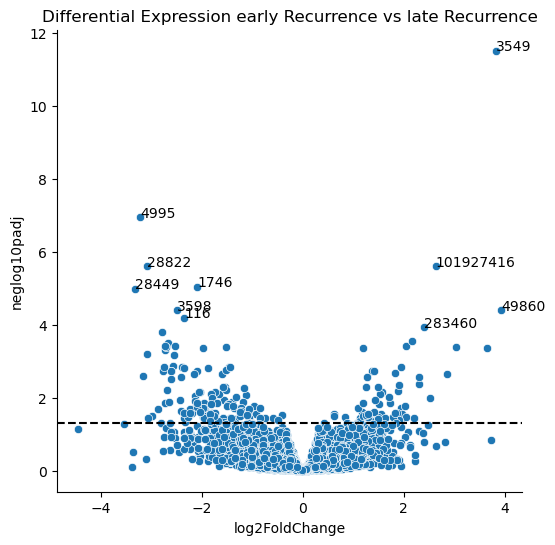

In [210]:
resdf['neglog10padj'] = -np.log10(resdf.padj)
Plot_volcano(resdf, 'log2FoldChange', 'neglog10padj', nlabel=10)

# Naming the genes

In [213]:
!pip install mygene

In [217]:
import mygene
# Initialize MyGeneInfo 
mg = mygene.MyGeneInfo()

In [219]:
# Extract all unique gene IDs from resdf
gene_ids = resdf['Gene'].unique().tolist()

In [221]:
# Query MyGene for gene symbols
gene_info = mg.querymany(gene_ids, scopes="entrezgene", fields="symbol", species="human")

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
85 input query terms found no hit:	['100506377', '100507415', '100873943', '100874233', '100874266', '100874283', '100874340', '1009963


In [222]:
# Create a mapping dictionary of gene ID and symbols
gene_dict = {entry['query']: entry.get('symbol', entry['query']) for entry in gene_info}

In [225]:
# Replace numerical Gene IDs with symbols
resdf['Gene'] = resdf['Gene'].map(gene_dict)

In [227]:
#show the results 
resdf

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,neglog10padj
0,A1BG,12.201617,0.235405,0.213901,1.100530,0.271101,0.782496,0.106518
1,NAT2,6.040187,0.490608,0.369342,1.328328,0.184070,0.716640,0.144699
2,ADA,659.381682,0.076812,0.142167,0.540297,0.588992,0.922728,0.034926
3,CDH2,4636.028956,0.144497,0.304722,0.474192,0.635363,0.935910,0.028766
4,AKT3,753.397311,-0.045769,0.254635,-0.179744,0.857353,0.980373,0.008609
...,...,...,...,...,...,...,...,...
40791,KCNE2,1.685431,-0.775093,0.370868,-2.089943,0.036623,0.443955,0.352661
40792,DGCR2,6791.719125,-0.119019,0.106440,-1.118182,0.263489,0.778500,0.108741
40793,CASP8AP2,899.177700,-0.249706,0.130412,-1.914747,0.055525,0.508759,0.293488
40794,ELK2BP,1.424381,-0.352071,0.352566,-0.998594,0.317991,0.812241,0.090315


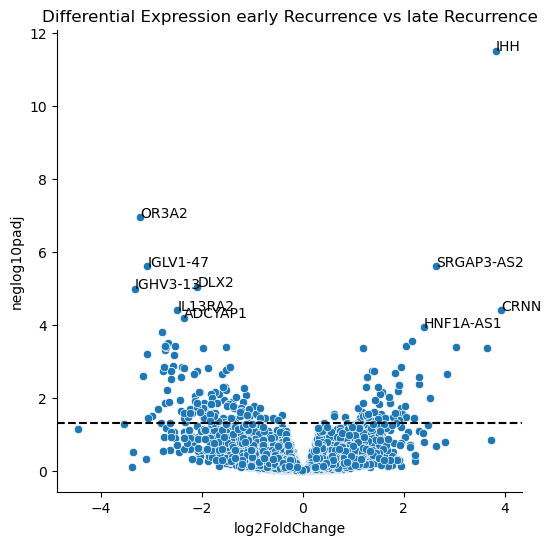

<Figure size 640x480 with 0 Axes>

In [237]:
# now rerun the volcano plot with the names of the genes 
resdf['neglog10padj'] = -np.log10(resdf.padj)
Plot_volcano(resdf, 'log2FoldChange', 'neglog10padj', nlabel=10)

#extract the plot as a figure for presentation and report
plt.savefig("Bulk_volcano2.png", dpi=300, bbox_inches="tight") 

# Violin Plots

In [243]:
#force numeric into the expression file to make sure it does not contain any other catergories 
expr_filt_T = expr_filt_T.apply(pd.to_numeric, errors='coerce')


In [245]:
#
expr_norm = deseq2_norm(expr_filt_T)[0]
expr_norm.index.name = "ID"
expr_norm

Gene,1,10,100,1000,10000,100008586,100009613,100009667,100009668,100009669,...,9988,9989,999,9990,9991,9992,9993,9994,9995,9997
ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,37.295626,4.143958,309.139297,3599.442271,289.248297,0.0,0.828792,0.828792,38.124417,0.0,...,3661.601648,4014.666904,7350.553421,1188.487271,5378.029219,0.000000,4787.100751,1600.396736,4.143958,17.404625
TCGA-04-1365,2.607922,7.823765,498.113050,6923.380209,135.611930,0.0,0.000000,1.955941,8.475746,0.0,...,1723.836263,3488.095312,10052.234303,908.860722,5161.077101,0.651980,5326.028150,1989.192299,0.651980,41.726748
TCGA-04-1519,5.211444,12.507466,409.619504,4833.093233,379.393129,0.0,10.422888,1.042289,22.930354,0.0,...,2392.052829,1428.977965,18585.051853,1013.104728,2594.256859,0.000000,7208.469442,626.415578,1.042289,5.211444
TCGA-04-1536,9.636256,3.212085,380.632103,5701.451326,388.662316,0.0,0.000000,1.606043,16.060426,0.0,...,1874.251746,2621.061567,25963.285108,843.172379,6727.712565,0.000000,11051.179317,1508.074027,1.606043,6.424171
TCGA-04-1651,5.077326,5.802659,693.417722,613.631164,106.623855,0.0,0.725332,1.450665,6.527991,0.0,...,2532.860550,2397.948734,9996.530383,842.110853,3726.032258,0.725332,7130.742287,1005.310631,2.901329,18.133309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-61-2088,55.001414,0.000000,264.222480,4102.458430,136.964306,0.0,2.156918,7.549214,17.255346,0.0,...,6079.273967,1787.006735,8500.414655,2956.056403,2425.454524,7.549214,3255.868034,1753.574503,3.235377,17.255346
TCGA-61-2098,31.568003,1.753778,531.979311,1075.065883,356.016924,0.0,0.000000,2.338371,15.199409,0.0,...,2335.447636,2271.727037,13848.999871,1533.971113,2420.213570,1.169185,5775.775379,1365.023837,0.000000,5.845926
TCGA-61-2101,4.806999,2.746856,558.298555,34012.262156,597.441258,0.0,4.120285,2.746856,1.373428,0.0,...,1772.409066,2377.404179,24330.966917,1084.321548,3612.802827,1.373428,18217.151376,608.428684,0.686714,4.806999


In [247]:
# check the columns in the metadata
progressed.columns

Index([          'Other Patient ID', 'Patient Primary Tumor Site',
                     'Disease Type',               'Project Name',
               'Project Identifier',                        'Sex',
                    'Race Category',         'Ethnicity Category',
           'Patient's Vital Status',              'Year of Death',
       ...
                                999,                         9990,
                               9991,                         9992,
                               9993,                         9994,
                               9995,                         9997,
                'DFS_STATUS_BINARY',        'recurrence_category'],
      dtype='object', length=40822)

In [285]:
#check the columns in the expression file 
expr_norm.columns

Index([        1,        10,       100,      1000,     10000, 100008586,
       100009613, 100009667, 100009668, 100009669,
       ...
            9988,      9989,       999,      9990,      9991,      9992,
            9993,      9994,      9995,      9997],
      dtype='int64', name='Gene', length=40796)

In [287]:
#access deseq2 normalized counts
expr_dds = deseq2_norm(expr_filt_T)[0]
expr_dds

Gene,1,10,100,1000,10000,100008586,100009613,100009667,100009668,100009669,...,9988,9989,999,9990,9991,9992,9993,9994,9995,9997
ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,37.295626,4.143958,309.139297,3599.442271,289.248297,0.0,0.828792,0.828792,38.124417,0.0,...,3661.601648,4014.666904,7350.553421,1188.487271,5378.029219,0.000000,4787.100751,1600.396736,4.143958,17.404625
TCGA-04-1365,2.607922,7.823765,498.113050,6923.380209,135.611930,0.0,0.000000,1.955941,8.475746,0.0,...,1723.836263,3488.095312,10052.234303,908.860722,5161.077101,0.651980,5326.028150,1989.192299,0.651980,41.726748
TCGA-04-1519,5.211444,12.507466,409.619504,4833.093233,379.393129,0.0,10.422888,1.042289,22.930354,0.0,...,2392.052829,1428.977965,18585.051853,1013.104728,2594.256859,0.000000,7208.469442,626.415578,1.042289,5.211444
TCGA-04-1536,9.636256,3.212085,380.632103,5701.451326,388.662316,0.0,0.000000,1.606043,16.060426,0.0,...,1874.251746,2621.061567,25963.285108,843.172379,6727.712565,0.000000,11051.179317,1508.074027,1.606043,6.424171
TCGA-04-1651,5.077326,5.802659,693.417722,613.631164,106.623855,0.0,0.725332,1.450665,6.527991,0.0,...,2532.860550,2397.948734,9996.530383,842.110853,3726.032258,0.725332,7130.742287,1005.310631,2.901329,18.133309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-61-2088,55.001414,0.000000,264.222480,4102.458430,136.964306,0.0,2.156918,7.549214,17.255346,0.0,...,6079.273967,1787.006735,8500.414655,2956.056403,2425.454524,7.549214,3255.868034,1753.574503,3.235377,17.255346
TCGA-61-2098,31.568003,1.753778,531.979311,1075.065883,356.016924,0.0,0.000000,2.338371,15.199409,0.0,...,2335.447636,2271.727037,13848.999871,1533.971113,2420.213570,1.169185,5775.775379,1365.023837,0.000000,5.845926
TCGA-61-2101,4.806999,2.746856,558.298555,34012.262156,597.441258,0.0,4.120285,2.746856,1.373428,0.0,...,1772.409066,2377.404179,24330.966917,1084.321548,3612.802827,1.373428,18217.151376,608.428684,0.686714,4.806999


In [289]:
# Rename expr_dds columns using the gene_dict mapping
expr_dds = expr_dds.rename(columns=gene_dict)

# Check if renaming worked
print(expr_dds.columns.tolist()[:10])

[1, 10, 100, 1000, 10000, 100008586, 100009613, 100009667, 100009668, 100009669]


In [291]:
# Convert all gene names to strings to avoid AttributeError
expr_dds.columns = expr_dds.columns.astype(str)
tmp["Gene"] = tmp["Gene"].astype(str)

# apply string functions
expr_dds.columns = expr_dds.columns.str.strip().str.upper()
tmp["Gene"] = tmp["Gene"].str.strip().str.upper()

# check
common_genes = set(tmp["Gene"]) & set(expr_dds.columns)
print({len(common_genes)})


{0}


In [293]:
# the naming did not work on the expr_dds data try to run mygene again
# Initialize MyGeneInfo
mg = mygene.MyGeneInfo()

# Extract all unique gene IDs from expr_dds (convert to list of strings)
gene_ids = expr_dds.columns.astype(str).tolist()

# Query MyGene for gene symbols
gene_info = mg.querymany(gene_ids, scopes="entrezgene", fields="symbol", species="human")

# Create a mapping dictionary {Entrez ID: Gene Symbol}
gene_dict = {entry['query']: entry.get('symbol', entry['query']) for entry in gene_info}

# Rename expr_dds columns using the mapping
expr_dds = expr_dds.rename(columns=gene_dict)

#view data to verify
expr_dds.columns.tolist()[:10]

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
85 input query terms found no hit:	['100506377', '100507415', '100873943', '100874233', '100874266', '100874283', '100874340', '1009963


['A1BG',
 'NAT2',
 'ADA',
 'CDH2',
 'AKT3',
 'GAGE12F',
 'LINC02584',
 'POU5F1P5',
 'POU5F1P6',
 'POU5F1P7']

In [281]:
expr_dds.columns

Index(['A1BG', 'NAT2', 'ADA', 'CDH2', 'AKT3', 'GAGE12F', 'LINC02584',
       'POU5F1P5', 'POU5F1P6', 'POU5F1P7',
       ...
       'DMTF1', 'PPP4R1', 'CDH1', 'SLC12A6', 'PTBP3', 'KCNE2', 'DGCR2',
       'CASP8AP2', 'ELK2BP', 'SCO2'],
      dtype='object', name='Gene', length=40796)

In [295]:
expr_dds

Gene,A1BG,NAT2,ADA,CDH2,AKT3,GAGE12F,LINC02584,POU5F1P5,POU5F1P6,POU5F1P7,...,DMTF1,PPP4R1,CDH1,SLC12A6,PTBP3,KCNE2,DGCR2,CASP8AP2,ELK2BP,SCO2
ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,37.295626,4.143958,309.139297,3599.442271,289.248297,0.0,0.828792,0.828792,38.124417,0.0,...,3661.601648,4014.666904,7350.553421,1188.487271,5378.029219,0.000000,4787.100751,1600.396736,4.143958,17.404625
TCGA-04-1365,2.607922,7.823765,498.113050,6923.380209,135.611930,0.0,0.000000,1.955941,8.475746,0.0,...,1723.836263,3488.095312,10052.234303,908.860722,5161.077101,0.651980,5326.028150,1989.192299,0.651980,41.726748
TCGA-04-1519,5.211444,12.507466,409.619504,4833.093233,379.393129,0.0,10.422888,1.042289,22.930354,0.0,...,2392.052829,1428.977965,18585.051853,1013.104728,2594.256859,0.000000,7208.469442,626.415578,1.042289,5.211444
TCGA-04-1536,9.636256,3.212085,380.632103,5701.451326,388.662316,0.0,0.000000,1.606043,16.060426,0.0,...,1874.251746,2621.061567,25963.285108,843.172379,6727.712565,0.000000,11051.179317,1508.074027,1.606043,6.424171
TCGA-04-1651,5.077326,5.802659,693.417722,613.631164,106.623855,0.0,0.725332,1.450665,6.527991,0.0,...,2532.860550,2397.948734,9996.530383,842.110853,3726.032258,0.725332,7130.742287,1005.310631,2.901329,18.133309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-61-2088,55.001414,0.000000,264.222480,4102.458430,136.964306,0.0,2.156918,7.549214,17.255346,0.0,...,6079.273967,1787.006735,8500.414655,2956.056403,2425.454524,7.549214,3255.868034,1753.574503,3.235377,17.255346
TCGA-61-2098,31.568003,1.753778,531.979311,1075.065883,356.016924,0.0,0.000000,2.338371,15.199409,0.0,...,2335.447636,2271.727037,13848.999871,1533.971113,2420.213570,1.169185,5775.775379,1365.023837,0.000000,5.845926
TCGA-61-2101,4.806999,2.746856,558.298555,34012.262156,597.441258,0.0,4.120285,2.746856,1.373428,0.0,...,1772.409066,2377.404179,24330.966917,1084.321548,3612.802827,1.373428,18217.151376,608.428684,0.686714,4.806999


In [259]:
#subset to significant genes, top10 upregulated and top10 downregulated
tmp = resdf.loc[resdf.padj<0.05]
tmp = tmp.sort_values("log2FoldChange")
tmp = pd.concat([tmp.head(20), tmp.tail(10)])
tmp

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,neglog10padj
22530,IGHV3-13,102.195180,-3.324913,0.555589,-5.984480,2.170816e-09,1.041666e-05,4.982271
28778,OR3A2,18.427683,-3.227737,0.471724,-6.842434,7.785871e-12,1.120815e-07,6.950466
23305,IGKV2-29,46.027711,-3.169436,0.686618,-4.616008,3.911926e-06,2.502850e-03,2.601565
23258,IGKV2D-40,70.837989,-3.092502,0.616556,-5.015771,5.282120e-07,6.336563e-04,3.198146
23221,IGLV1-47,1558.472208,-3.083698,0.488635,-6.310838,2.775280e-10,2.545012e-06,5.594310
18675,XAGE3,4.699417,-3.070954,0.828076,-3.708544,2.084545e-04,3.637342e-02,1.439216
13615,LBX1,11.468721,-2.978080,0.783902,-3.799046,1.452544e-04,3.075014e-02,1.512153
23237,IGKV1OR22-5,2.689950,-2.862356,0.724070,-3.953146,7.713022e-05,2.057902e-02,1.686575
617,TDRD15,1.389711,-2.815612,0.785433,-3.584788,3.373519e-04,4.930303e-02,1.307126
22344,IGHV4-61,114.920829,-2.796958,0.516028,-5.420171,5.954217e-08,1.558435e-04,3.807311


In [251]:
# Ensure they both have the same name index name
progressed.index.name = "ID"  
expr_norm.index.name = "ID"

# Merge using index
toplot = progressed.merge(expr_norm, left_index=True, right_index=True, how="inner")

# Display merged data
toplot.head()


,Other Patient ID,Patient Primary Tumor Site,Disease Type,Project Name,Project Identifier,Sex,Race Category,Ethnicity Category,Patient's Vital Status,Year of Death,...,9988_y,9989_y,999_y,9990_y,9991_y,9992_y,9993_y,9994_y,9995_y,9997_y
ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,6d10d4ee-6331-4bba-93bc-a7b64cc0b22a,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2007,...,3661.601648,4014.666904,7350.553421,1188.487271,5378.029219,0.000000,4787.100751,1600.396736,4.143958,17.404625
TCGA-04-1365,0484a929-7a7f-4926-8d25-470ddab082ec,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Alive,NaN,...,1723.836263,3488.095312,10052.234303,908.860722,5161.077101,0.651980,5326.028150,1989.192299,0.651980,41.726748
TCGA-04-1519,e9b5336e-d724-4e7d-8c81-1147abd0a80d,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,NaN,NaN,Alive,NaN,...,2392.052829,1428.977965,18585.051853,1013.104728,2594.256859,0.000000,7208.469442,626.415578,1.042289,5.211444
TCGA-04-1536,1fe19c6b-71d0-4b07-923b-74ea32210db0,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,BLACK OR AFRICAN AMERICAN,NaN,Dead,2003,...,1874.251746,2621.061567,25963.285108,843.172379,6727.712565,0.000000,11051.179317,1508.074027,1.606043,6.424171
TCGA-04-1651,55153632-1673-487a-85c0-f156377db1fc,Ovary,"Cystic, Mucinous and Serous Neoplasms",Ovarian Serous Cystadenocarcinoma,TCGA-OV,Female,WHITE,NOT HISPANIC OR LATINO,Dead,2007,...,2532.860550,2397.948734,9996.530383,842.110853,3726.032258,0.725332,7130.742287,1005.310631,2.901329,18.133309


In [297]:
# make sure that the columns are strings to aviod errors
toplot.columns = toplot.columns.astype(str)

C:\Users\mahal\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 18.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\mahal\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 29.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='recurrence_category', ylabel='3549_y'>

C:\Users\mahal\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 51.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\mahal\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 60.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


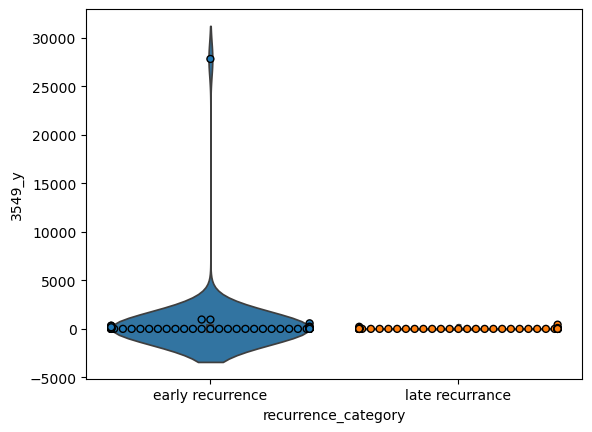

In [299]:
# swarmplot and violinplot
sns.swarmplot(data=toplot, x="recurrence_category", y="3549_y", hue="recurrence_category", edgecolor="black", linewidth=1)
sns.violinplot(data=toplot, x="recurrence_category", y="3549_y", hue="recurrence_category")

In [301]:
#subset to top10 genes by fold change
toheat = expr_dds.loc[:, expr_dds.columns.isin(tmp.Gene)]

#z-score normalize gene expression
toheat = toheat.apply(stats.zscore)
toheat


Gene,TDRD15,RNA5S9,CMKLR2-AS,SRGAP3-AS2,IGHV1-69D,LBX1,TEX26,XAGE3,HNF1A-AS1,IGHV4-61,...,IGLC6,IHH,LINC02899,CRNN,OR3A2,SERPINA4,PRB1,PRB2,CAPNS2,GALP
ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,-0.198253,-0.236184,-0.252913,-0.196793,-0.230115,-0.138799,-0.237132,-0.202393,-0.133749,-0.301533,...,-0.248283,-0.107508,-0.205702,-0.135668,1.748747,-0.108828,0.121723,0.127729,-0.308541,-0.242137
TCGA-04-1365,-0.160317,-0.277365,-0.269096,-0.256641,-0.043162,-0.126336,-0.212525,-0.202393,-0.138840,0.167194,...,-0.240249,-0.110356,-0.208765,-0.149805,-0.301780,-0.124666,-0.189015,-0.171363,0.031661,-0.226377
TCGA-04-1519,-0.198253,-0.225575,-0.269096,-0.290777,-0.231215,-0.138799,-0.237132,-0.170875,-0.139309,-0.322059,...,-0.262295,-0.113049,-0.204912,-0.155469,-0.271598,-0.124666,-0.189015,-0.119036,-0.308541,-0.235839
TCGA-04-1536,-0.198253,0.041841,-0.269096,-0.295502,-0.226242,-0.138799,-0.176517,-0.178110,-0.112385,-0.322059,...,-0.235142,-0.112004,-0.208765,-0.145004,-0.270187,-0.118528,-0.189015,-0.136515,-0.099034,-0.242137
TCGA-04-1651,-0.198253,-0.277365,-0.254933,-0.289874,-0.231215,0.523656,-0.209757,-0.202393,-0.126874,-0.322059,...,-0.164192,-0.110518,-0.208765,-0.127113,-0.299351,-0.121894,-0.189015,-0.195178,7.450227,-0.242137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-61-2088,-0.177336,-0.170192,-0.269096,-0.210199,-0.231215,-0.138799,3.222600,-0.202393,-0.129577,-0.322059,...,-0.262295,-0.112197,0.213818,-0.155469,-0.287657,-0.124666,-0.152257,-0.195178,-0.167857,-0.222586
TCGA-61-2098,-0.130223,-0.277365,5.712294,-0.164169,-0.230439,-0.126383,7.440945,-0.202393,-0.074104,-0.320611,...,-0.262295,-0.108034,-0.206604,-0.145312,3.741949,-0.124666,-0.089388,-0.166707,1.064134,-0.242137
TCGA-61-2101,-0.171615,-0.277365,-0.215461,-0.297799,-0.213291,-0.131506,-0.237132,-0.202393,-0.137484,-0.306753,...,-0.239075,-0.112533,-0.208765,-0.155469,-0.312000,-0.122041,-0.189015,-0.161734,-0.218960,-0.242137


# Heat Map

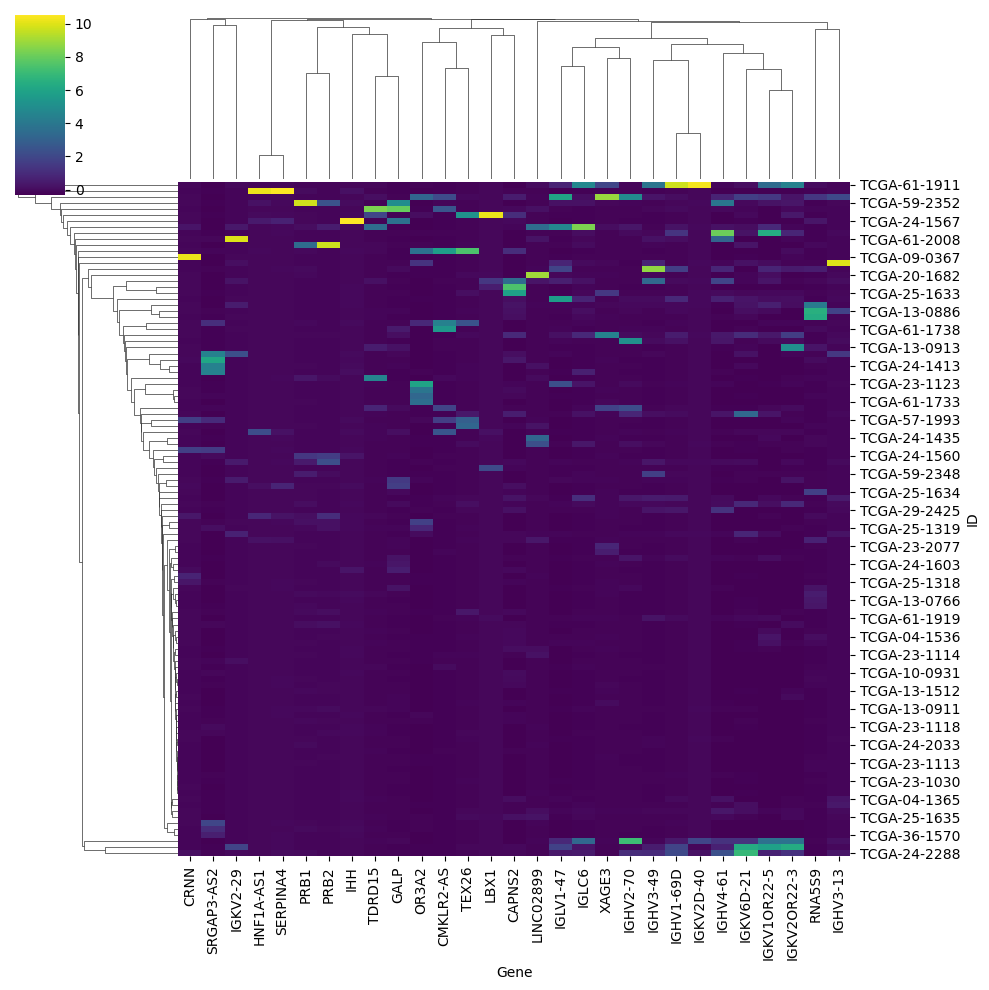

In [304]:
sns.clustermap(toheat, cmap='viridis')
plt.show()


In [306]:
from scipy.stats import zscore

# Normalize each gene 
toheat_scaled = toheat.apply(zscore, axis=1)

# Replace NaNs if any 
toheat_scaled = toheat_scaled.fillna(0)


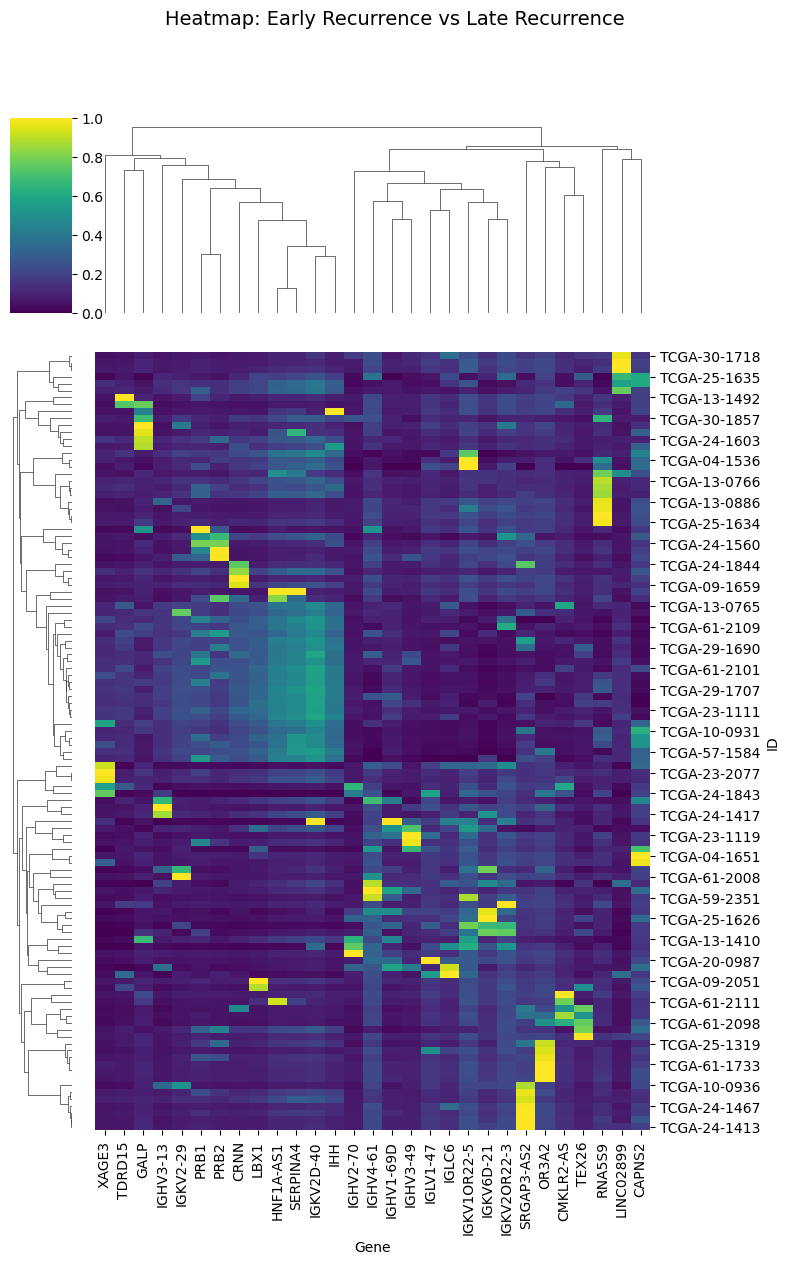

In [308]:
#try to run a normalized heat map function
g = sns.clustermap(
    toheat_scaled,  
    cmap="viridis",  
    metric="correlation",  
    method="average",  
    standard_scale=1,  
    figsize=(8,12),  
    dendrogram_ratio=(0.1, 0.2),  
    cbar_pos=(0.02, 0.8, 0.05, 0.18)  
)

plt.suptitle("Heatmap: Early Recurrence vs Late Recurrence", fontsize=14, y=1.05)
plt.tight_layout()

# Save the figure
plt.savefig("heatmap2.png", dpi=300, bbox_inches="tight") 

#show the plot
plt.show(g)



# MFA Analysis FIGO stage vs recurrence category

In [311]:
progressed["FIGO Stage"] = progressed["FIGO Stage"].astype("category")
progressed["recurrence_category"] = progressed["recurrence_category"].astype("category")

In [313]:
progressed.columns = progressed.columns.str.replace(" ", "_")

In [315]:
dds = DeseqDataSet(
    counts=expr_filt_T,
    metadata= progressed[['FIGO_Stage', 'recurrence_category']],
    design_factors=["FIGO_Stage", "recurrence_category"],  #differential expression on genotype adjusted for region
    #pass the main design  lat in the list within the design factors
    refit_cooks=True,
    inference=inference,
)

C:\Users\mahal\anaconda3\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\mahal\AppData\Local\Temp\ipykernel_12448\4188045585.py:1: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(


In [317]:
dds.deseq2()

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.34 seconds.

Fitting dispersions...
... done in 42.01 seconds.

Fitting dispersion trend curve...
... done in 1.73 seconds.

Fitting MAP dispersions...
... done in 61.74 seconds.

Fitting LFCs...
... done in 25.27 seconds.

Calculating cook's distance...
... done in 0.63 seconds.

Replacing 2095 outlier genes.

Fitting dispersions...
... done in 2.34 seconds.

Fitting MAP dispersions...
... done in 2.25 seconds.

Fitting LFCs...
... done in 2.25 seconds.



In [319]:
print(dds.varm["LFC"])

       Intercept  FIGO_Stage[T.Stage III]  FIGO_Stage[T.Stage IV]  \
Gene                                                                
1       2.841937                -0.299259               -0.031690   
10     -0.726920                 2.716482                2.398757   
100     6.450108                 0.051696                0.179405   
1000    7.454445                 1.090229                0.565133   
10000   6.838570                -0.230578               -0.276885   
...          ...                      ...                     ...   
9992    0.295455                -0.252211                0.796738   
9993    8.709936                 0.080276                0.002532   
9994    6.405811                 0.318670                0.201796   
9995    0.184854                -0.023459               -0.024359   
9997    3.272043                -0.165465               -0.368490   

       recurrence_category[T.late recurrance]  
Gene                                           
1     

In [321]:
stat_res2 = stat_res = DeseqStats(dds, contrast=["recurrence_category", 'early recurrence', 'late recurrance' ], inference=inference)
stat_res2.summary()

Running Wald tests...
... done in 10.39 seconds.



Log2 fold change & Wald test p-value: recurrence_category early recurrence vs late recurrance
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Gene                                                                      
1        12.201617        0.222385  0.215087  1.033931  0.301168  0.795670
10        6.040187        0.421274  0.365977  1.151095  0.249693  0.760092
100     659.381682        0.063007  0.143620  0.438706  0.660875  0.939406
1000   4636.028956        0.106593  0.303674  0.351012  0.725579  0.954575
10000   753.397311       -0.032708  0.257375 -0.127082  0.898875  0.986246
...            ...             ...       ...       ...       ...       ...
9992      1.685431       -0.712802  0.360326 -1.978212  0.047905  0.464705
9993   6791.719125       -0.118643  0.107631 -1.102315  0.270325  0.776048
9994    899.177700       -0.262401  0.130999 -2.003082  0.045168  0.453166
9995      1.424381       -0.352930  0.356695 -0.989444  0.322446  0.809781
9997  

In [323]:
resdf2 = stat_res2.results_df.reset_index()
resdf2

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,1,12.201617,0.222385,0.215087,1.033931,0.301168,0.795670
1,10,6.040187,0.421274,0.365977,1.151095,0.249693,0.760092
2,100,659.381682,0.063007,0.143620,0.438706,0.660875,0.939406
3,1000,4636.028956,0.106593,0.303674,0.351012,0.725579,0.954575
4,10000,753.397311,-0.032708,0.257375,-0.127082,0.898875,0.986246
...,...,...,...,...,...,...,...
40791,9992,1.685431,-0.712802,0.360326,-1.978212,0.047905,0.464705
40792,9993,6791.719125,-0.118643,0.107631,-1.102315,0.270325,0.776048
40793,9994,899.177700,-0.262401,0.130999,-2.003082,0.045168,0.453166
40794,9995,1.424381,-0.352930,0.356695,-0.989444,0.322446,0.809781


In [325]:
resdf2.loc[resdf2.padj<0.05].sort_values("padj")

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
22539,28454,417.522309,-4.002357,0.578165,-6.922514,4.436975e-12,1.221943e-07
24965,3549,45.661471,3.093271,0.482111,6.416097,1.398128e-10,1.925223e-06
22530,28449,205.262875,-3.464379,0.579670,-5.976464,2.280327e-09,2.093340e-05
23221,28822,2062.383910,-2.891468,0.501143,-5.769744,7.939183e-09,5.466127e-05
34462,653247,8.778835,3.541004,0.623397,5.680177,1.345553e-08,7.411307e-05
...,...,...,...,...,...,...,...
19184,202333,327.430831,0.785115,0.220471,3.561083,3.693278e-04,4.954880e-02
23225,28826,59.124259,-2.011212,0.565889,-3.554078,3.793069e-04,4.970837e-02
25727,388125,587.338463,1.282572,0.361073,3.552109,3.821565e-04,4.970837e-02
24876,3507,7978.681019,-1.654902,0.465715,-3.553464,3.801937e-04,4.970837e-02


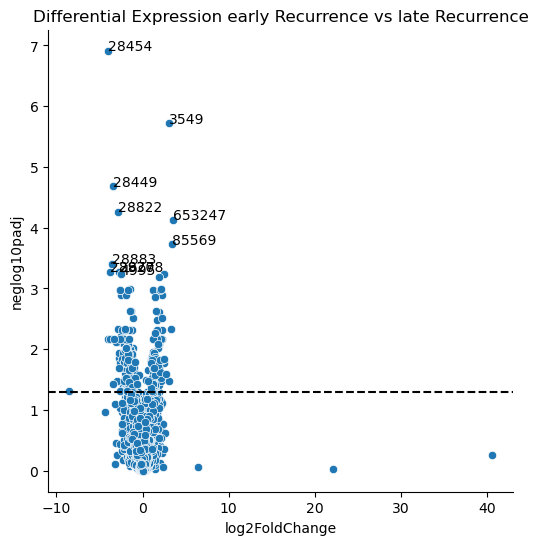

In [327]:
resdf2['neglog10padj'] = -np.log10(resdf2.padj)
Plot_volcano(resdf2, 'log2FoldChange', 'neglog10padj', nlabel=10)

In [329]:
#Rename and Initialize MyGeneInfo 
mg = mygene.MyGeneInfo()

# Extract all unique gene IDs from resdf2
gene_ids = resdf2['Gene'].unique().tolist()

# Query MyGene for gene symbols
gene_info = mg.querymany(gene_ids, scopes="entrezgene", fields="symbol", species="human")

# Create a mapping dictionary {Gene ID: Gene Symbol}
gene_dict = {entry['query']: entry.get('symbol', entry['query']) for entry in gene_info}

# Replace numerical Gene IDs with symbols
resdf2['Gene'] = resdf2['Gene'].map(gene_dict)

# Save the updated DataFrame to a CSV file
resdf2.to_csv("resdf2_with_symbols.csv", index=False)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
85 input query terms found no hit:	['100506377', '100507415', '100873943', '100874233', '100874266', '100874283', '100874340', '1009963


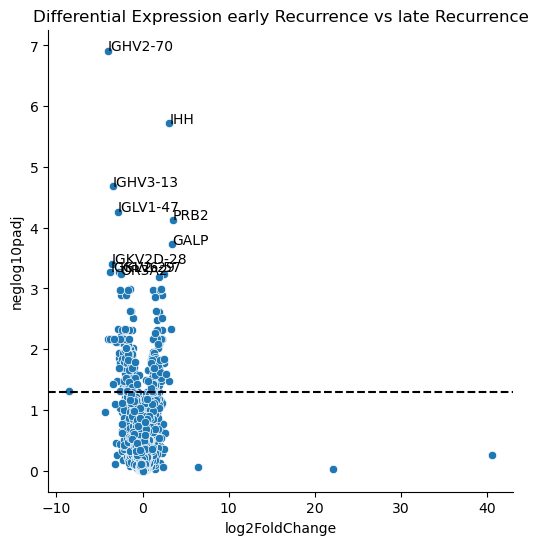

In [331]:
resdf2['neglog10padj'] = -np.log10(resdf2.padj)
Plot_volcano(resdf2, 'log2FoldChange', 'neglog10padj', nlabel=10)

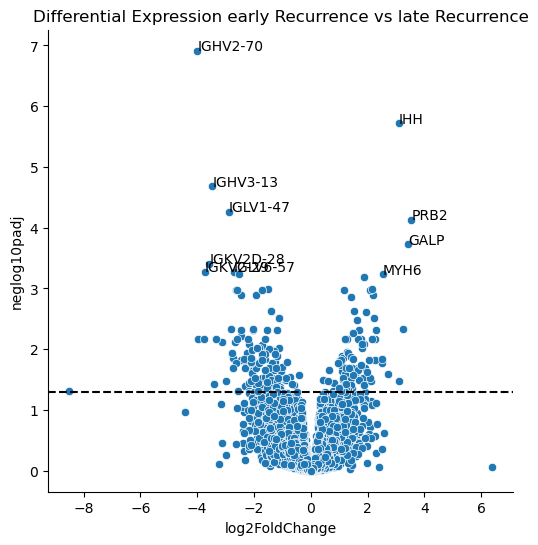

<Figure size 640x480 with 0 Axes>

In [601]:
resdf2 = resdf2[(resdf2['log2FoldChange'] <= 10) & (resdf2['log2FoldChange'] >= -10)]
resdf2['neglog10padj'] = -np.log10(resdf2.padj)
Plot_volcano(resdf2, 'log2FoldChange', 'neglog10padj', nlabel=10)
# Save the figure AFTER plotting
plt.gcf().savefig("MFA.png", dpi=300, bbox_inches='tight')


In [333]:
#access deseq2 normalized counts
expr_dds2 = deseq2_norm(expr_filt_T)[0]
expr_dds2

Gene,1,10,100,1000,10000,100008586,100009613,100009667,100009668,100009669,...,9988,9989,999,9990,9991,9992,9993,9994,9995,9997
ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,37.295626,4.143958,309.139297,3599.442271,289.248297,0.0,0.828792,0.828792,38.124417,0.0,...,3661.601648,4014.666904,7350.553421,1188.487271,5378.029219,0.000000,4787.100751,1600.396736,4.143958,17.404625
TCGA-04-1365,2.607922,7.823765,498.113050,6923.380209,135.611930,0.0,0.000000,1.955941,8.475746,0.0,...,1723.836263,3488.095312,10052.234303,908.860722,5161.077101,0.651980,5326.028150,1989.192299,0.651980,41.726748
TCGA-04-1519,5.211444,12.507466,409.619504,4833.093233,379.393129,0.0,10.422888,1.042289,22.930354,0.0,...,2392.052829,1428.977965,18585.051853,1013.104728,2594.256859,0.000000,7208.469442,626.415578,1.042289,5.211444
TCGA-04-1536,9.636256,3.212085,380.632103,5701.451326,388.662316,0.0,0.000000,1.606043,16.060426,0.0,...,1874.251746,2621.061567,25963.285108,843.172379,6727.712565,0.000000,11051.179317,1508.074027,1.606043,6.424171
TCGA-04-1651,5.077326,5.802659,693.417722,613.631164,106.623855,0.0,0.725332,1.450665,6.527991,0.0,...,2532.860550,2397.948734,9996.530383,842.110853,3726.032258,0.725332,7130.742287,1005.310631,2.901329,18.133309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-61-2088,55.001414,0.000000,264.222480,4102.458430,136.964306,0.0,2.156918,7.549214,17.255346,0.0,...,6079.273967,1787.006735,8500.414655,2956.056403,2425.454524,7.549214,3255.868034,1753.574503,3.235377,17.255346
TCGA-61-2098,31.568003,1.753778,531.979311,1075.065883,356.016924,0.0,0.000000,2.338371,15.199409,0.0,...,2335.447636,2271.727037,13848.999871,1533.971113,2420.213570,1.169185,5775.775379,1365.023837,0.000000,5.845926
TCGA-61-2101,4.806999,2.746856,558.298555,34012.262156,597.441258,0.0,4.120285,2.746856,1.373428,0.0,...,1772.409066,2377.404179,24330.966917,1084.321548,3612.802827,1.373428,18217.151376,608.428684,0.686714,4.806999


In [335]:
#subset to significant genes, top10+/- by fold change
tmp2 = resdf2.loc[resdf2.padj<0.05]
tmp2 = tmp2.sort_values("log2FoldChange")
tmp2 = pd.concat([tmp2.head(15), tmp2.tail(15)])
tmp2

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,neglog10padj
23191,IGLV3-22,51.049617,-8.504235,2.380963,-3.571763,3.545860e-04,4.810492e-02,1.317810
22539,IGHV2-70,417.522309,-4.002357,0.578165,-6.922514,4.436975e-12,1.221943e-07,6.912949
617,TDRD15,3.073498,-3.988112,0.907018,-4.396948,1.097836e-05,6.791184e-03,2.168055
22550,IGHV1-69-2,96.820801,-3.744688,0.858981,-4.359454,1.303875e-05,6.855814e-03,2.163941
23305,IGKV2-29,151.587382,-3.729184,0.713728,-5.224939,1.742123e-07,5.330897e-04,3.273200
23264,IGKV2D-28,92.751500,-3.571709,0.670499,-5.326940,9.988106e-08,3.929606e-04,3.405651
22530,IGHV3-13,205.262875,-3.464379,0.579670,-5.976464,2.280327e-09,2.093340e-05,4.679160
25720,IGHV1OR15-1,1.638839,-3.427022,0.932196,-3.676290,2.366508e-04,3.724208e-02,1.428966
27709,LINC02899,56.474842,-3.344380,0.768334,-4.352771,1.344277e-05,6.855814e-03,2.163941
23237,IGKV1OR22-5,2.689950,-3.135804,0.726132,-4.318501,1.570924e-05,7.725578e-03,2.112069


In [347]:
# Rename expr_dds columns using the gene_dict mapping
expr_dds2 = expr_dds2.rename(columns=gene_dict)

expr_dds2.columns


Index(['A1BG', 'NAT2', 'ADA', 'CDH2', 'AKT3', 'GAGE12F', 'LINC02584',
       'POU5F1P5', 'POU5F1P6', 'POU5F1P7',
       ...
       'DMTF1', 'PPP4R1', 'CDH1', 'SLC12A6', 'PTBP3', 'KCNE2', 'DGCR2',
       'CASP8AP2', 'ELK2BP', 'SCO2'],
      dtype='object', name='Gene', length=40796)

In [349]:
expr_dds2

Gene,A1BG,NAT2,ADA,CDH2,AKT3,GAGE12F,LINC02584,POU5F1P5,POU5F1P6,POU5F1P7,...,DMTF1,PPP4R1,CDH1,SLC12A6,PTBP3,KCNE2,DGCR2,CASP8AP2,ELK2BP,SCO2
ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331,37.295626,4.143958,309.139297,3599.442271,289.248297,0.0,0.828792,0.828792,38.124417,0.0,...,3661.601648,4014.666904,7350.553421,1188.487271,5378.029219,0.000000,4787.100751,1600.396736,4.143958,17.404625
TCGA-04-1365,2.607922,7.823765,498.113050,6923.380209,135.611930,0.0,0.000000,1.955941,8.475746,0.0,...,1723.836263,3488.095312,10052.234303,908.860722,5161.077101,0.651980,5326.028150,1989.192299,0.651980,41.726748
TCGA-04-1519,5.211444,12.507466,409.619504,4833.093233,379.393129,0.0,10.422888,1.042289,22.930354,0.0,...,2392.052829,1428.977965,18585.051853,1013.104728,2594.256859,0.000000,7208.469442,626.415578,1.042289,5.211444
TCGA-04-1536,9.636256,3.212085,380.632103,5701.451326,388.662316,0.0,0.000000,1.606043,16.060426,0.0,...,1874.251746,2621.061567,25963.285108,843.172379,6727.712565,0.000000,11051.179317,1508.074027,1.606043,6.424171
TCGA-04-1651,5.077326,5.802659,693.417722,613.631164,106.623855,0.0,0.725332,1.450665,6.527991,0.0,...,2532.860550,2397.948734,9996.530383,842.110853,3726.032258,0.725332,7130.742287,1005.310631,2.901329,18.133309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-61-2088,55.001414,0.000000,264.222480,4102.458430,136.964306,0.0,2.156918,7.549214,17.255346,0.0,...,6079.273967,1787.006735,8500.414655,2956.056403,2425.454524,7.549214,3255.868034,1753.574503,3.235377,17.255346
TCGA-61-2098,31.568003,1.753778,531.979311,1075.065883,356.016924,0.0,0.000000,2.338371,15.199409,0.0,...,2335.447636,2271.727037,13848.999871,1533.971113,2420.213570,1.169185,5775.775379,1365.023837,0.000000,5.845926
TCGA-61-2101,4.806999,2.746856,558.298555,34012.262156,597.441258,0.0,4.120285,2.746856,1.373428,0.0,...,1772.409066,2377.404179,24330.966917,1084.321548,3612.802827,1.373428,18217.151376,608.428684,0.686714,4.806999


# Compare to scRNA


In [431]:
# this list was obtained from our teammates who worked on scRNA as their DEGs
genes_of_interest = [
    "WFDC2", "KRT8", "EPCAM", "CD24", "LEFTY1", "RPL3", "ANXA4", "GSTP1", "CXCL1",
    "SPP1", "S100A6", "SPARC", "COL1A2", "COL3A1", "FN1", "FAP", "ACTA2", "SERPINE1",
    "HMGB2", "MKI67", "CENPF", "UBE2C", "CD74", "HLA-B", "SRGN", "CD14", "LYZ",
    "PTPRC", "CD163", "CD86", "CD3D", "CD3G", "CD8A", "XCL1", "LAMP3", "MS4A1", "CD27"
]


# Ensure the Gene column is treated as a string
resdf["Gene"] = resdf["Gene"].astype(str)

# Find if genes are in the dataset
genes_found = resdf[resdf["Gene"].isin(genes_of_interest)]

# show resulted 
genes_found

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,neglog10padj,highlight
1531,CD24,72489.821200,-0.225003,0.221491,-1.015859,0.309697,0.809553,0.091755,Bulk and scRNA-seq
9264,WFDC2,98052.367417,0.209648,0.240443,0.871925,0.383249,0.849096,0.071043,Bulk and scRNA-seq
10535,CENPF,3995.532897,-0.026972,0.156932,-0.171869,0.863541,0.981274,0.008210,Bulk and scRNA-seq
10543,LEFTY1,22.098816,0.057627,0.302856,0.190277,0.849092,0.980099,0.008730,Bulk and scRNA-seq
14698,UBE2C,6167.961107,-0.045412,0.174048,-0.260916,0.794158,0.972577,0.012076,Bulk and scRNA-seq
16652,COL1A2,114487.890324,-0.119002,0.266897,-0.445872,0.655690,0.942061,0.025921,Bulk and scRNA-seq
16672,COL3A1,87790.014009,-0.237526,0.313182,-0.758427,0.448195,0.876894,0.057053,Bulk and scRNA-seq
19391,FAP,581.327223,-0.200309,0.357519,-0.560276,0.575291,0.918647,0.036851,Bulk and scRNA-seq
20227,FN1,76123.800232,-0.251308,0.287044,-0.875503,0.381301,0.847978,0.071615,Bulk and scRNA-seq
21756,LAMP3,1995.347796,0.339210,0.255656,1.326822,0.184567,0.716992,0.144486,Bulk and scRNA-seq


In [433]:
# Define pvalue and logfc thershold
logfc_threshold = 1  
pval_threshold = 0.05  

# Filter the bulk RNA-seq dataset to include only scRNA-seq genes
bulk_filtered = resdf[resdf["Gene"].isin(genes_of_interest)].copy()

In [435]:
# Add regulation status
bulk_filtered["Regulation"] = bulk_filtered.apply(
    lambda row: "Upregulated" if row["log2FoldChange"] > logfc_threshold and row["pvalue"] < pval_threshold else
                "Downregulated" if row["log2FoldChange"] < -logfc_threshold and row["pvalue"] < pval_threshold else
                "Not Significant", axis=1
)


bulk_filtered[["Gene", "log2FoldChange", "pvalue", "Regulation"]]


,Gene,log2FoldChange,pvalue,Regulation
1531,CD24,-0.225003,0.309697,Not Significant
9264,WFDC2,0.209648,0.383249,Not Significant
10535,CENPF,-0.026972,0.863541,Not Significant
10543,LEFTY1,0.057627,0.849092,Not Significant
14698,UBE2C,-0.045412,0.794158,Not Significant
16652,COL1A2,-0.119002,0.655690,Not Significant
16672,COL3A1,-0.237526,0.448195,Not Significant
19391,FAP,-0.200309,0.575291,Not Significant
20227,FN1,-0.251308,0.381301,Not Significant
21756,LAMP3,0.339210,0.184567,Not Significant


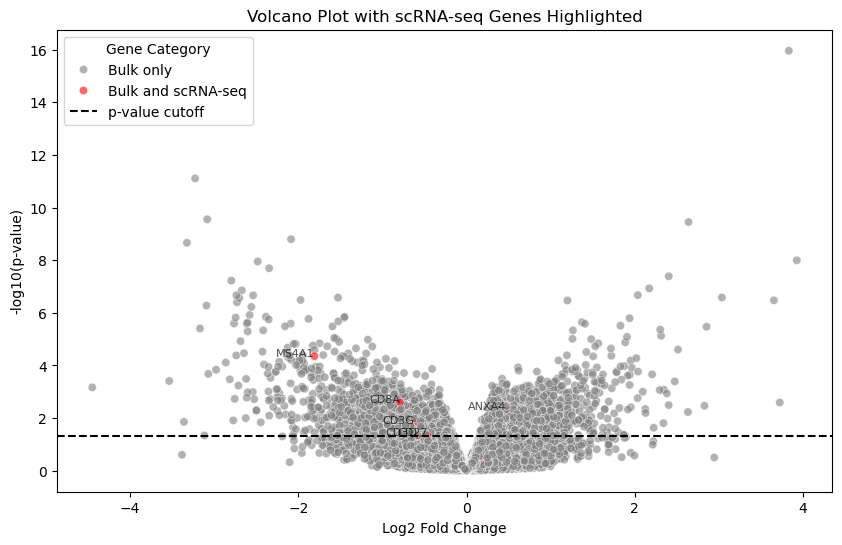

In [559]:
# Define significance threshold for labeling genes
pval_threshold = 0.05

# Create the volcano plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=resdf, x="log2FoldChange", y=-np.log10(resdf["pvalue"]),
    hue="highlight", palette={"Bulk and scRNA-seq": "red", "Bulk only": "gray"}, alpha=0.6
)

# Draw horizontal cutoff line
plt.axhline(y=-np.log10(pval_threshold), linestyle="--", color="black", label="p-value cutoff")

# Label only scRNA-seq genes that are significantly differentially expressed
for _, row in resdf[(resdf["highlight"] == "Bulk and scRNA-seq") & (resdf["pvalue"] < pval_threshold)].iterrows():
    plt.text(row["log2FoldChange"], -np.log10(row["pvalue"]), row["Gene"],
             fontsize=8, ha='right', color='black', alpha=0.7)

plt.xlabel("Log2 Fold Change")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot with scRNA-seq Genes Highlighted")
plt.legend(title="Gene Category")

# Save the figure
plt.savefig("volcano_plot.png", dpi=300, bbox_inches="tight") 

plt.show()


# Compare to Fibroblast gens

In [439]:
# this list was obtained from literture search
genes_of_interest2 = ["COL1A2", "COL4A1", "COL1A1", "SPARC", "VIM"]


# Ensure the Gene column is treated as a string
resdf["Gene"] = resdf["Gene"].astype(str)

# Find if genes are in the dataset
genes_found2 = resdf[resdf["Gene"].isin(genes_of_interest2)]

# show resulted 
genes_found2

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,neglog10padj,highlight
16645,COL1A1,269527.324176,-0.058961,0.298464,-0.197547,0.843400,0.978560,0.009412,Bulk only
16652,COL1A2,114487.890324,-0.119002,0.266897,-0.445872,0.655690,0.942061,0.025921,Bulk and scRNA-seq
16688,COL4A1,14499.210758,-0.048087,0.169569,-0.283581,0.776731,0.969979,0.013238,Bulk only
34784,SPARC,71764.013765,-0.044227,0.239798,-0.184433,0.853674,0.980373,0.008609,Bulk and scRNA-seq
36363,VIM,29106.583507,-0.059832,0.183177,-0.326633,0.743946,0.964091,0.015882,Bulk only


In [440]:
# Define pvalue and logfc thershold
logfc_threshold = 1  
pval_threshold = 0.05  

# Filter the bulk RNA-seq dataset to include only scRNA-seq genes
bulk_filtered2 = resdf[resdf["Gene"].isin(genes_of_interest2)].copy()

In [441]:
# Add regulation status
bulk_filtered2["Regulation"] = bulk_filtered2.apply(
    lambda row: "Upregulated" if row["log2FoldChange"] > logfc_threshold and row["pvalue"] < pval_threshold else
                "Downregulated" if row["log2FoldChange"] < -logfc_threshold and row["pvalue"] < pval_threshold else
                "Not Significant", axis=1
)


bulk_filtered2[["Gene", "log2FoldChange", "pvalue", "Regulation"]]


,Gene,log2FoldChange,pvalue,Regulation
16645,COL1A1,-0.058961,0.843400,Not Significant
16652,COL1A2,-0.119002,0.655690,Not Significant
16688,COL4A1,-0.048087,0.776731,Not Significant
34784,SPARC,-0.044227,0.853674,Not Significant
36363,VIM,-0.059832,0.743946,Not Significant


# Compare to stemness genes 

In [447]:
# this list was obtained from literture search
genes_of_interest3 =  ["THBS1", "CDKN1A", "CD44", "CD133", "DYRK1A", "DIRAS3", "FBXW7", "NFATC4", "ARHI", "NTN1", "SOX2", "NDP"]


# Ensure the Gene column is treated as a string
resdf["Gene"] = resdf["Gene"].astype(str)

# Find if genes are in the dataset
genes_found3 = resdf[resdf["Gene"].isin(genes_of_interest3)]

# show resulted 
genes_found3

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,neglog10padj,highlight
8769,CDKN1A,2979.320797,0.023756,0.188061,0.126323,0.899476,0.987469,0.005476,Bulk only
18859,DYRK1A,4294.233868,0.044358,0.087570,0.506540,0.612477,0.928119,0.032396,Bulk only
28450,NDP,405.984259,0.611377,0.363803,1.680516,0.092857,0.590280,0.228942,Bulk only
28540,NFATC4,2900.002000,-0.093292,0.184442,-0.505804,0.612994,0.928152,0.032381,Bulk only
30660,FBXW7,634.633554,-0.162146,0.099485,-1.629859,0.103131,0.606837,0.216928,Bulk only
34763,SOX2,269.141291,-0.058500,0.490681,-0.119222,0.905100,0.988616,0.004972,Bulk only
35383,THBS1,10898.604426,-0.069009,0.256350,-0.269199,0.787777,0.971573,0.012525,Bulk only
39622,DIRAS3,286.300126,0.918967,0.288734,3.182750,0.001459,0.106602,0.972234,Bulk only
40238,NTN1,2560.635503,0.402183,0.243273,1.653215,0.098287,0.596438,0.224435,Bulk only
40410,CD44,4838.757358,0.118077,0.203497,0.580242,0.561751,0.914136,0.038989,Bulk only


In [449]:
# Define pvalue and logfc thershold
logfc_threshold = 1  
pval_threshold = 0.05  

# Filter the bulk RNA-seq dataset to include only scRNA-seq genes
bulk_filtered3 = resdf[resdf["Gene"].isin(genes_of_interest3)].copy()

In [451]:
# Add regulation status
bulk_filtered3["Regulation"] = bulk_filtered3.apply(
    lambda row: "Upregulated" if row["log2FoldChange"] > logfc_threshold and row["pvalue"] < pval_threshold else
                "Downregulated" if row["log2FoldChange"] < -logfc_threshold and row["pvalue"] < pval_threshold else
                "Not Significant", axis=1
)


bulk_filtered3[["Gene", "log2FoldChange", "pvalue", "Regulation"]]


,Gene,log2FoldChange,pvalue,Regulation
8769,CDKN1A,0.023756,0.899476,Not Significant
18859,DYRK1A,0.044358,0.612477,Not Significant
28450,NDP,0.611377,0.092857,Not Significant
28540,NFATC4,-0.093292,0.612994,Not Significant
30660,FBXW7,-0.162146,0.103131,Not Significant
34763,SOX2,-0.058500,0.905100,Not Significant
35383,THBS1,-0.069009,0.787777,Not Significant
39622,DIRAS3,0.918967,0.001459,Not Significant
40238,NTN1,0.402183,0.098287,Not Significant
40410,CD44,0.118077,0.561751,Not Significant


In [453]:
# this list was obtained from literture search
genes_of_interest4 =  ["FOCK2", "NOTCH3", "SOX2", "PAX8", "CXCR4", "NANOG", "ABCG2"]

# Ensure the Gene column is treated as a string
resdf["Gene"] = resdf["Gene"].astype(str)

# Find if genes are in the dataset
genes_found4 = resdf[resdf["Gene"].isin(genes_of_interest4)]

# show resulted 
genes_found4

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,neglog10padj,highlight
28606,NOTCH3,18075.478516,0.054532,0.177429,0.307348,0.758578,0.965905,0.015066,Bulk only
34763,SOX2,269.141291,-0.058500,0.490681,-0.119222,0.905100,0.988616,0.004972,Bulk only
36702,PAX8,21721.610917,0.140497,0.171863,0.817495,0.413646,0.861784,0.064602,Bulk only
36706,CXCR4,7516.729415,0.164176,0.196001,0.837632,0.402238,0.856699,0.067172,Bulk only
37281,NANOG,8.361069,0.909249,0.324903,2.798527,0.005134,0.201748,0.695191,Bulk only
40251,ABCG2,146.936247,0.225658,0.181025,1.246563,0.212558,0.738936,0.131393,Bulk only


In [463]:
# Define pvalue and logfc thershold
logfc_threshold = 1  
pval_threshold = 0.05  

# Filter the bulk RNA-seq dataset to include only scRNA-seq genes
bulk_filtered4 = resdf[resdf["Gene"].isin(genes_of_interest4)].copy()

In [465]:
# Add regulation status
bulk_filtered4["Regulation"] = bulk_filtered3.apply(
    lambda row: "Upregulated" if row["log2FoldChange"] > logfc_threshold and row["pvalue"] < pval_threshold else
                "Downregulated" if row["log2FoldChange"] < -logfc_threshold and row["pvalue"] < pval_threshold else
                "Not Significant", axis=1
)


bulk_filtered4[["Gene", "log2FoldChange", "pvalue", "Regulation"]]


,Gene,log2FoldChange,pvalue,Regulation
28606,NOTCH3,0.054532,0.758578,NaN
34763,SOX2,-0.058500,0.905100,Not Significant
36702,PAX8,0.140497,0.413646,NaN
36706,CXCR4,0.164176,0.402238,NaN
37281,NANOG,0.909249,0.005134,NaN
40251,ABCG2,0.225658,0.212558,NaN


# GSEA Analysis
now I am shifting from DESEq2 to GSEA analysis

In [470]:
pip install gseapy

Note: you may need to restart the kernel to use updated packages.


In [472]:
pip install numpy scipy pandas matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


In [474]:
import pandas as pd
import numpy as np
import os
import gseapy as gp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import ttest_ind

In [480]:
# Load DEGs list with log fold-change (logFC) values
deg_df = pd.read_csv("../resdf_with_symbols.csv")

In [482]:
#drop any empty cells
filtered = deg_df.dropna(subset=["log2FoldChange"])
filtered.to_csv("degs.csv")

In [484]:
#check columns
filtered.columns

Index(['Gene', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj',
       'neglog10padj'],
      dtype='object')

In [486]:
#check index
filtered.index

Index([    0,     1,     2,     3,     4,     6,     7,     8,    10,    11,
       ...
       40786, 40787, 40788, 40789, 40790, 40791, 40792, 40793, 40794, 40795],
      dtype='int64', length=38461)

In [488]:
filtered.set_index("Gene")

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,neglog10padj
Gene,,,,,,,
A1BG,12.201617,0.235405,0.213901,1.100530,0.271101,0.782496,0.106518
NAT2,6.040187,0.490608,0.369342,1.328328,0.184070,0.716640,0.144699
ADA,659.381682,0.076812,0.142167,0.540297,0.588992,0.922728,0.034926
CDH2,4636.028956,0.144497,0.304722,0.474192,0.635363,0.935910,0.028766
AKT3,753.397311,-0.045769,0.254635,-0.179744,0.857353,0.980373,0.008609
...,...,...,...,...,...,...,...
KCNE2,1.685431,-0.775093,0.370868,-2.089943,0.036623,0.443955,0.352661
DGCR2,6791.719125,-0.119019,0.106440,-1.118182,0.263489,0.778500,0.108741
CASP8AP2,899.177700,-0.249706,0.130412,-1.914747,0.055525,0.508759,0.293488


In [490]:
#renaming the columns because I was having an issue with running the code
filtered = filtered.rename(columns={"pvalue": "pval", "padj": "fdr"})

#check the names
print(filtered.columns.tolist())

['Gene', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pval', 'fdr', 'neglog10padj']


In [492]:
# Remove rows where pvalue or padj is missing
filtered = filtered.dropna(subset=["pval", "fdr"])  

In [496]:
# order genes by log fold-change for GSEA
ranked_genes = filtered.set_index("Gene")["log2FoldChange"].sort_values(ascending=False)

# Run GSEA using KEGG pathways
gsea_results = gp.prerank(
    rnk=ranked_genes,
    gene_sets="KEGG_2021_Human",
    outdir="gsea_results",  # Save results
    permutation_num=100,
    seed=42
)

# Display significant pathways
print(gsea_results.res2d[["Term", "NES", "NOM p-val", "FDR q-val"]])


                                         Term       NES NOM p-val FDR q-val
0                          Salivary secretion  2.083917       0.0       0.0
1         Complement and coagulation cascades  2.024786       0.0       0.0
2        Maturity onset diabetes of the young  1.930618       0.0  0.016048
3                         Thiamine metabolism  1.817426       0.0  0.018054
4                         Folate biosynthesis  1.807883       0.0  0.014443
..                                        ...       ...       ...       ...
301               Aminoacyl-tRNA biosynthesis  0.496395       1.0       1.0
302                    Fanconi anemia pathway -0.454135       1.0       1.0
303               Basal transcription factors -0.447281       1.0  0.999449
304                           Mismatch repair   0.44167  0.974359       1.0
305  Vasopressin-regulated water reabsorption  0.437913       1.0  0.999773

[306 rows x 4 columns]


In [498]:
# Print available columns in gsea_results.res2d to know what I am working with
print(gsea_results.res2d.columns.tolist())


['Name', 'Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val', 'FWER p-val', 'Tag %', 'Gene %', 'Lead_genes']


In [500]:
# Define cutoffs
logfc_threshold = 1
pval_threshold = 0.05

# Separate upregulated and downregulated genes
upregulated = filtered[(filtered["log2FoldChange"] > logfc_threshold) & (filtered["pval"] < pval_threshold)]
downregulated = filtered[(filtered["log2FoldChange"] < -logfc_threshold) & (filtered["pval"] < pval_threshold)]

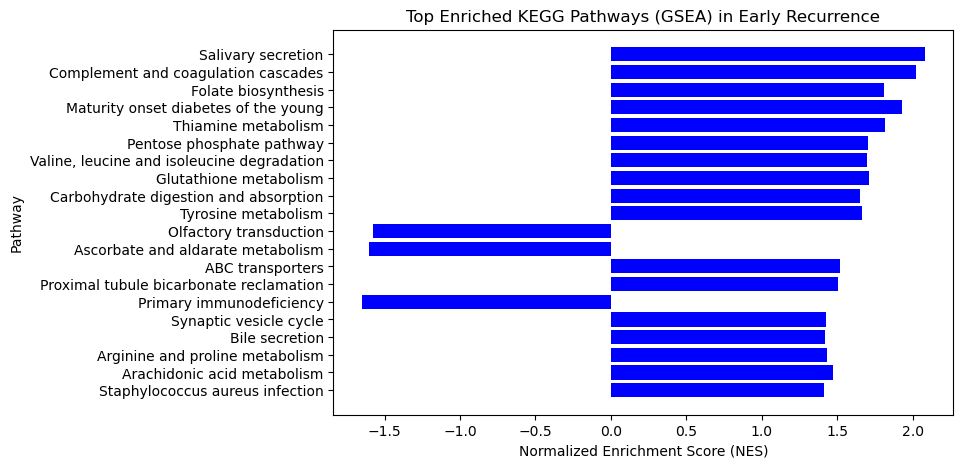

In [561]:
# Select top 10 enriched pathways
top_pathways = gsea_results.res2d.sort_values("FDR q-val").head(20)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(top_pathways["Term"], top_pathways["NES"], color="blue")
plt.xlabel("Normalized Enrichment Score (NES)")
plt.ylabel("Pathway")
plt.title("Top Enriched KEGG Pathways (GSEA) in Early Recurrence")
plt.gca().invert_yaxis()
# Save the figure
plt.savefig("KEGG", dpi=300, bbox_inches="tight") 

plt.show()


# Hallmark Analysis

In [505]:
import requests

# URL for Hallmark gene set (latest version might need checking)
url = "https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.1.Hs/h.all.v2023.1.Hs.symbols.gmt"

# Save the file locally
gmt_file = "h.all.v2023.1.Hs.symbols.gmt"
response = requests.get(url)
with open(gmt_file, "wb") as f:
    f.write(response.content)


In [507]:
#show the list of avaible pathways in the library
libs = gp.get_library_name(organism='Human')
libs

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

In [509]:
# Run GSEA using Hallmark
gsea_results_hallmark = gp.prerank(
    rnk=ranked_genes,
    gene_sets="h.all.v2023.1.Hs.symbols.gmt",
    permutation_num=100,
    seed=42
)

# Display significant pathways
gsea_results_hallmark.res2d[["Term", "NES", "NOM p-val", "FDR q-val"]]

,Term,NES,NOM p-val,FDR q-val
0,HALLMARK_PANCREAS_BETA_CELLS,1.94371,0.0,0.0
1,HALLMARK_ESTROGEN_RESPONSE_LATE,1.870033,0.0,0.0
2,HALLMARK_COAGULATION,1.762297,0.0,0.0
3,HALLMARK_ESTROGEN_RESPONSE_EARLY,1.701815,0.0,0.0164
4,HALLMARK_XENOBIOTIC_METABOLISM,1.563157,0.0,0.052481
5,HALLMARK_ANGIOGENESIS,1.430174,0.0625,0.098402
6,HALLMARK_ALLOGRAFT_REJECTION,-1.420694,0.0,0.196274
7,HALLMARK_TNFA_SIGNALING_VIA_NFKB,1.40474,0.0,0.098402
8,HALLMARK_P53_PATHWAY,1.389494,0.0,0.086102
9,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,1.377952,0.02381,0.087468


In [511]:
# Define cutoffs
logfc_threshold = 1
pval_threshold = 0.05

# Separate upregulated and downregulated genes
upregulated = filtered[(filtered["log2FoldChange"] > logfc_threshold) & (filtered["pval"] < pval_threshold)]
downregulated = filtered[(filtered["log2FoldChange"] < -logfc_threshold) & (filtered["pval"] < pval_threshold)]

In [513]:
upregulated.head()

,Gene,baseMean,log2FoldChange,lfcSE,stat,pval,fdr,neglog10padj
927,LINC00552,7.058107,1.130962,0.552099,2.048478,0.040513,0.460183,0.337070
1051,ERLN,66.963289,1.404843,0.388698,3.614228,0.000301,0.046630,1.331337
1098,VHRT,1.155303,1.087408,0.497123,2.187402,0.028713,0.405236,0.392292
1178,ECEL1P1,20.898777,1.328024,0.539592,2.461163,0.013849,0.307179,0.512608
1327,ABCB10P4,1.200446,2.125875,0.749157,2.837691,0.004544,0.191528,0.717767


In [515]:
downregulated.head()

,Gene,baseMean,log2FoldChange,lfcSE,stat,pval,fdr,neglog10padj
165,LIN28B-AS1,1.656520,-1.047407,0.476322,-2.198949,0.027882,0.400799,0.397073
394,XIAPP3,0.964217,-1.165048,0.475142,-2.451997,0.014207,0.310807,0.507509
465,NIFKP4,0.921326,-1.024033,0.432022,-2.370325,0.017772,0.340420,0.467985
502,BNIP3P34,3.228751,-1.472633,0.562274,-2.619068,0.008817,0.262270,0.581252
617,TDRD15,1.389711,-2.815612,0.785433,-3.584788,0.000337,0.049303,1.307126


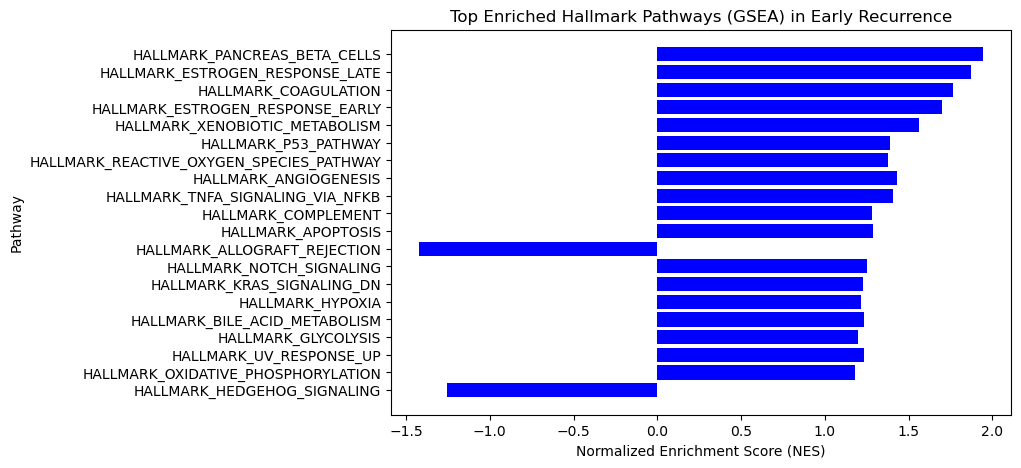

In [563]:
# plot top 20 enriched pathways
top_pathways = gsea_results_hallmark.res2d.sort_values("FDR q-val").head(20)

plt.figure(figsize=(8, 5))
plt.barh(top_pathways["Term"], top_pathways["NES"], color="blue")
plt.xlabel("Normalized Enrichment Score (NES)")
plt.ylabel("Pathway")
plt.title("Top Enriched Hallmark Pathways (GSEA) in Early Recurrence")
plt.gca().invert_yaxis()

#save the plot into my files
plt.savefig("Hallmark_plot.png", dpi=300, bbox_inches="tight")


plt.show()



# GO GSEA


In [524]:
import requests

# links for GO gene sets
go_bp_url = "https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.1.Hs/c5.go.bp.v2023.1.Hs.symbols.gmt"
go_cc_url = "https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.1.Hs/c5.go.cc.v2023.1.Hs.symbols.gmt"
go_mf_url = "https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.1.Hs/c5.go.mf.v2023.1.Hs.symbols.gmt"

# Download and save files
for url, name in zip([go_bp_url, go_cc_url, go_mf_url],
                     ["c5.go.bp.gmt", "c5.go.cc.gmt", "c5.go.mf.gmt"]):
    response = requests.get(url)
    with open(name, "wb") as f:
        f.write(response.content)

In [526]:

response = requests.get(go_mf_url)
if response.status_code == 200:
    with open("c5.go.mf.gmt", "wb") as f:
        f.write(response.content)

In [532]:
# Remove NaN values
rnk_df = filtered[['Gene', 'log2FoldChange']].dropna()

#save file 
rnk_df.to_csv("ranked_genes.rnk", sep="\t", index=False, header=False)


In [548]:
with open("ranked_genes.rnk", "r") as f:
    for _ in range(5): 
        print(f.readline().strip())

A1BG	0.2354045278288555
NAT2	0.4906078899410522
ADA	0.0768122578411141
CDH2	0.1444966719924316
AKT3	-0.0457691303182595


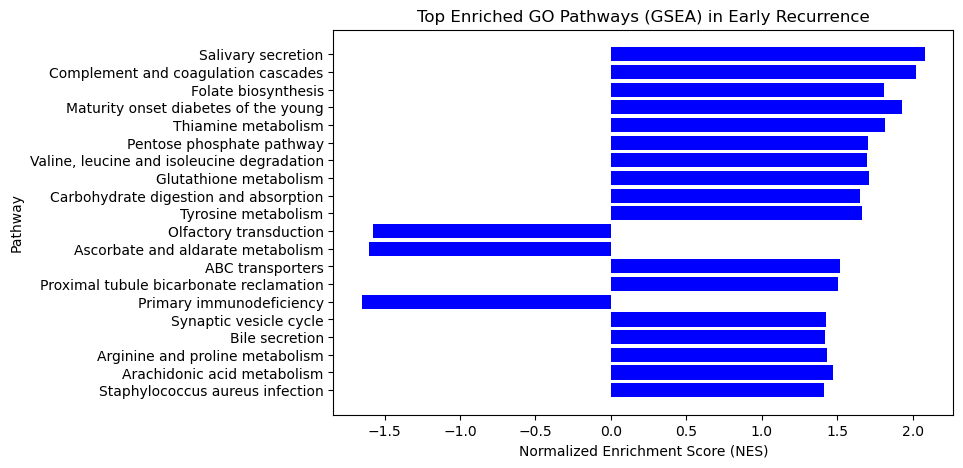

In [565]:
# Select top 10 enriched pathways
top_pathways = gsea_results.res2d.sort_values("FDR q-val").head(20)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(top_pathways["Term"], top_pathways["NES"], color="blue")
plt.xlabel("Normalized Enrichment Score (NES)")
plt.ylabel("Pathway")
plt.title("Top Enriched GO Pathways (GSEA) in Early Recurrence")
plt.gca().invert_yaxis()
# Save the figure
plt.savefig("GO.png", dpi=300, bbox_inches="tight") 

plt.show()

# ECM Remodelling Pathways Exploration